### [주제] 지역에 따라서 (청년층의) 일자리에 대한 질적인 차이가 존재하는가?

지방 소멸이라는 주제에서 중요하게 다뤄지는 내용 중 하나는 '청년층의 지방 이탈'이고, 청년층의 지방 이탈이 발생하는 이유로는  
지방보다 도시에서의 구직활동이 보다 쉽기 때문이라고 여겨진다. 수도권 지역에서 구인활동이 더 활발하기 때문이다.  

전체 인구의 절반 가까이 수도권에 모여 산다는 것을 생각하면, 수도권 지역에서의 구인구직 활동이 다수 이뤄진다는 것은 당연한 사실이며,  
자료(https://sgis.kostat.go.kr/view/workRoad/main) 를 통해서 사실을 확인할 수 있다.  

하지만, 단순히 수적인 차이가 아니라 질적인 차이가 존재하는지에 대해 의문을 갖게 되었다.  
여기서 말하는 질적인 차이는 다음 두 가지로 구체화 할 수 있을 것이다.

1. 인구수 대비 구인 발생 건수를 비교하여, 해당 지표상 지방보다 수도권이 우수하다.  
2. 제안하는 연봉 및 근무조건이 전체적으로 지방보다 수도권이 우수하다.  

그리고 둘 중에서 1번 대신, 데이터 수집 및 분석 역량이 더 요구되는 2번에 대해 분석을 수행하기로 결정하였다.

정리하자면, 지방 소멸의 원인 중 하나를 ＇구인구직 활동을 위해 지방을 이탈하는 청년층이 다수 존재하기 때문＇ 으로 생각하고,  
신입 대상 구인공고 데이터를 수집하여 <h4>＂근무환경이 전체적으로 지방보다 수도권이 우수한지＂ </h4> 를 분석하고자 한다.  

'근무환경' 은 '인크루트' 에서 구인 공고 데이터를 바탕으로 정의하였다.  
수집한 데이터 항목은 다음과 같다.  

    "region", # 지역  
    "cpname", # 회사이름  
    "title", # 구인공고 제목  
    "career", # 요구 경력  
    "education", # 요구 학력  
    "jobtype", # 고용 형태 (정규직, 비정규직, ...)  
    "cptype", # 회사 규모 형태 (대기업, 중견, 중소, ...)  
    "sales", # 회사 연매출  
    "employees", # 회사 근무 직원 수  
    "aversalary", # 회사 근무 직원 평균 연봉  
    "capital", # 회사 자본금  
    "pros", # 인크루트에 등록된 '입사지원하면 좋은 이유' 들  

<br></br>

해당 주제를 검증하기 위해 세 가지 가설을 설정하였다.  

1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도 학습).  

지역에 따라 일자리의 질적인 수준이 명확하게 나뉠수록, 구인 공고 데이터를 모아서 지역을 예측할 때 정확도가 높은 모델을 만들기 쉬울 것이다.

2. {수도권, 비수도권 광역시, 그 외 지방} 지역 중에서, 수도권 지역이 ＇대기업 및 중견기업이 내건 구인공고 비중＇이 가장 크고 그 외 지방 지역이 해당 공고 비중이 가장 작을 것이다.  

3. 구인 공고 데이터 피쳐를 바탕으로 클러스터링 시에  크게 그룹 {우수한 일자리 / 중간 / 상대적으로 별로인 일자리} 로  나눌  수 있을 것이며, 수도권에 가까울수록 우수한 일자리 그룹에 소속된 데이터포인트가 다수일 것이다. (비지도 학습)

만약 가설 3이 맞는다면, 수집한 데이터가 유의미한 정보를 포함하고 있다는 의미일 것이다.

### 분석 의의  

가설이 모두 참이라면, 단순히 지방지역의 청년층의 일자리 수 증가만 요구되는 것이 아니라  
청년층의 지방이탈을 방지하기 위해 질적인 측면에서의 개선도 필요함을 주장하는 근거 자료로 해당 분석 결과를 사용할 수 있다.

In [1]:
import re
import pandas as pd
import numpy as np

### 데이터 피쳐 설명
    
    "region", # 지역
    "cpname", # 회사이름
    "title", # 구인공고 제목
    "career", # 요구 경력
    "education", # 요구 학력
    "jobtype", # 고용 형태 (정규직, 비정규직, ...)
    "cptype", # 회사 규모 형태 (대기업, 중견, 중소, ...)
    "sales", # 회사 연매출
    "employees", # 회사 근무 직원 수 
    "aversalary", # 회사 근무 직원 평균 연봉
    "capital", # 회사 자본금
    "pros", # 인크루트에 등록된 '입사지원하면 좋은 이유' 들

In [2]:
# 17개 지역
regions = {
    "11": "서울",
    "12": "부산",
    "14": "인천",
    "16": "대전",
    "15": "광주",
    "13": "대구",
    "17": "울산",
    "27": "세종",
    "18": "경기",
    "19": "강원특별자치도",
    "20": "충북",
    "21": "충남",
    "22": "전북특별자치도",
    "23": "전남",
    "24": "경북",
    "25": "경남",
    "26": "제주",
}


# 수도권 : 서울, 인천, 세종, 경기
# 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
# 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주

features = [
    "region", # 지역
    "cpname", # 회사이름
    "title", # 구인공고 제목
    "career", # 요구 경력
    "education", # 요구 학력
    "jobtype", # 고용 형태 (정규직, 비정규직, ...)
    "cptype", # 회사 규모 형태 (대기업, 중견, 중소, ...)
    "sales", # 회사 연매출
    "employees", # 회사 근무 직원 수 
    "aversalary", # 회사 근무 직원 평균 연봉
    "capital", # 회사 자본금
    "pros", # 인크루트에 등록된 '입사지원하면 좋은 이유' 들
]
df = pd.DataFrame(columns=features)

for region in regions.values():
    df_subset = pd.read_csv(f"sample data/raw_data_{region}.csv", index_col=0)
    df = pd.concat([df, df_subset])

df = df.reset_index(drop=True)

df.to_csv("raw_data.csv", encoding="utf-8-sig")

In [3]:
df = pd.read_csv('raw_data.csv', encoding='utf-8-sig', index_col=0)

In [4]:
df.drop('cpname', axis=1, inplace=True)
df.drop('title', axis=1, inplace=True)
# 'career' 항목은 데이터 크롤링 과정에서 신입/연차 무관 으로 사전에 필터링 되었으므로 필요없다.
df.drop('career', axis=1, inplace=True)
df.head()

,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros
0,서울,대졸이상,정규직,중견기업,"1조 8,090억 8,204만원 (2023)","2,036 명 재직중","9,516만원\n자세히보기","778억 1,959만원",안정적인 장수 회사-성장판 열린 회사-구직자 인기기업-복지의 끝판왕-매출 1조 클럽...
1,서울,학력무관,인턴,대기업,"6조 885억 8,200만원 (2023)","1,657 명 재직중","5,083만원\n자세히보기","6,486억 5,400만원",안정적인 장수 회사-성장판 열린 회사-복지의 끝판왕-매출 1조 클럽-아침을 왜 굶어...
2,서울,학력무관,인턴,중기업,"113조 7,600억 976만원 (2022)","15,761 명 재직중","6,176만원\n자세히보기",-,성장판 열린 회사-구직자 인기기업-채용에 적극적인 회사-매출 1조 클럽-HOT한 인...
3,서울,학력무관,정규직,중견기업,"25조 4,700억원 (2022)","18,000 명 재직중",-,-,안정적인 장수 회사-구직자 인기기업-채용에 적극적인 회사-HOT한 인기기업
4,서울,학력무관,정규직외,중견기업,"6,569억 5,188만원 (2022)","2,610 명 재직중","6,244만원\n자세히보기","2조 3,577억 6,610만원",성장판 열린 회사-구직자 인기기업-채용에 적극적인 회사-HOT한 인기기업-집 걱정 ...


In [5]:
print(df['education'].value_counts())
print(df['jobtype'].value_counts())
print(df['cptype'].value_counts())

education
학력무관     1779
고졸이상      398
대졸이상      354
초대졸이상     291
고졸         56
대졸         52
초대졸        44
석사이상       25
박사이상       14
석사          1
박사          1
Name: count, dtype: int64
jobtype
정규직         1455
계약직          462
정규직외         451
위촉직          158
위촉직외         134
인턴            88
계약직외          86
알바            66
프리랜서          55
교육생(연수생)      50
파견직            5
알바외            2
인턴외            1
병역특례           1
대체인력           1
Name: count, dtype: int64
cptype
중소기업    1444
중견기업     675
대기업      673
소기업      152
중기업       69
무입력        2
Name: count, dtype: int64


### 인코딩

범주에 따라 다른 점수를 부여하고 싶어서 범주형 데이터에 대해 수동으로 라벨 인코딩 수행  

In [6]:
df['education'] = df['education'].replace({
    '학력무관': 0,
    '고졸': 1,
    '고졸이상': 1,
    '초대졸' : 2,
    '초대졸이상': 2,
    '대졸': 3,
    '대졸이상': 3,
    '석사' : 4,
    '석사이상' : 4,
    '박사' : 5,
    '박사이상' : 5
},)

def encode_cptype(x : str):
    if x == '대기업':
        return 2
    elif x == '중견기업':
        return 1
    else:
        return 0
    

df['jobtype'] = df['jobtype'].map(lambda x : 1 if x == '정규직' else 0)

df['cptype'] = df['cptype'].map(encode_cptype)

C:\Users\user\AppData\Local\Temp\ipykernel_5680\4072464947.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['education'] = df['education'].replace({


In [7]:
print(df['education'].value_counts())
print(df['jobtype'].value_counts())
print(df['cptype'].value_counts())
df.head()

education
0    1779
1     454
3     406
2     335
4      26
5      15
Name: count, dtype: int64
jobtype
0    1560
1    1455
Name: count, dtype: int64
cptype
0    1667
1     675
2     673
Name: count, dtype: int64


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros
0,서울,3,1,1,"1조 8,090억 8,204만원 (2023)","2,036 명 재직중","9,516만원\n자세히보기","778억 1,959만원",안정적인 장수 회사-성장판 열린 회사-구직자 인기기업-복지의 끝판왕-매출 1조 클럽...
1,서울,0,0,2,"6조 885억 8,200만원 (2023)","1,657 명 재직중","5,083만원\n자세히보기","6,486억 5,400만원",안정적인 장수 회사-성장판 열린 회사-복지의 끝판왕-매출 1조 클럽-아침을 왜 굶어...
2,서울,0,0,0,"113조 7,600억 976만원 (2022)","15,761 명 재직중","6,176만원\n자세히보기",-,성장판 열린 회사-구직자 인기기업-채용에 적극적인 회사-매출 1조 클럽-HOT한 인...
3,서울,0,1,1,"25조 4,700억원 (2022)","18,000 명 재직중",-,-,안정적인 장수 회사-구직자 인기기업-채용에 적극적인 회사-HOT한 인기기업
4,서울,0,0,1,"6,569억 5,188만원 (2022)","2,610 명 재직중","6,244만원\n자세히보기","2조 3,577억 6,610만원",성장판 열린 회사-구직자 인기기업-채용에 적극적인 회사-HOT한 인기기업-집 걱정 ...


### 인코딩 
수집한 지역을 {수도권, 비수도권 광역시, 그 외 지방} 중 하나로 분류 및 숫자값으로 라벨 인코딩  

In [8]:
# 수도권 : 서울, 인천, 세종, 경기
# 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
# 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주

def encode_region(x : str):
    if x == '서울' or x =='인천' or x =='세종' or x =='경기':
        return 2
    elif x == '부산' or x == '대구'or x == '광주'or x =='대전' or x =='울산':
        return 1
    else:
        return 0
    

df['region'] = df['region'].map(encode_region)

In [9]:
print(df['region'].value_counts())

region
0    1424
1     876
2     715
Name: count, dtype: int64


### 인코딩  
'pros' 피쳐는 문자열 값이므로 이에 대한 처리 수행

'pros' 값을 점수로 변환하여 'pros_encoded' 피쳐로 변환하여 처리  
이에 대한 점수 기준표는 tags_encoded.csv 파일에 등록.  
점수로 변환하기 이전 'pros' 문자열 값들은 tags.csv 파일에 등록되어있다.  

'매출 1000대 기업', '대기업', 'KOSPI 상장' 등 객관적인 평가지표가 반영된 항목이면서 기업역량이 우수함을 쉽게 판단할 수 있는 항목에 주로 5점,  
'육아휴직 제공', '자기 계발비 지원' 등 해당 항목이 부여된 기준을 알기 어렵고, 사실을 검증하기 어려운 항목들에 대해서는 1점을 주는 식으로 평가하였다.

In [10]:
tags_encoded = pd.read_csv('tags_encoded.csv', encoding='utf-8-sig', index_col=0)
# tags_encoded.head()
tags_score = dict(zip(tags_encoded['tags'], tags_encoded['score']))
tags_score

{'안정적인 장수 회사': 5,
 '성장판 열린 회사': 3,
 '구직자 인기기업': 5,
 '채용에 적극적인 회사': 3,
 '복지의 끝판왕': 1,
 '매출 1조 클럽': 5,
 '매출 상위 10%': 5,
 'HOT한 인기기업': 5,
 '아침을 왜 굶어요?': 1,
 '평균연봉 6천이상': 3,
 '신입연봉이 4천이상': 3,
 '스타트업 초봉 3,500만원↗': 3,
 '지방에 위치한 대기업': 5,
 '자기계발비 지원 기업': 1,
 '보너스로 행복해요♥': 1,
 '내 출퇴근은 내 맘대로': 1,
 '아낌없이 주는 커피': 1,
 '아이와 함께 출근해요': 1,
 '잘나가는 의료·바이오기업': 5,
 '주 4일 근무': 3,
 '집 걱정 안 하기': 3,
 '거침없이 성장하는 회사': 3,
 '매출 1000대 기업': 5,
 '인크루트 인증 우수기업': 3,
 '대기업 in 서울': 5,
 '공기업 in 서울': 5,
 '장기근속수당제공 기업': 3,
 '육아휴직 제공 기업': 1,
 'KOSPI 상장': 5,
 'KOSDAQ 상장': 5,
 '빵빵한 구내식당': 1,
 '휴식까지 챙겨줘요!': 1,
 'KONEX 상장': 3}

In [11]:
def encodeTagsByScore(tags: str):
    if isinstance(tags, float): return tags
    total_score = 0
    for tag in tags.split('-'):
        if tag !=  '':
            total_score += tags_score[tag]
    return total_score

df['pros_encoded'] = df['pros'].apply(encodeTagsByScore)
df['pros_encoded']

0       50.0
1       31.0
2       29.0
3       18.0
4       32.0
        ... 
3010     NaN
3011     NaN
3012     NaN
3013     1.0
3014     3.0
Name: pros_encoded, Length: 3015, dtype: float64

### 데이터 형변환  
문자열 값으로 수집된 데이터 실수형 데이터로 변환  

In [12]:
# 띄어쓰기, 콤마(',') 제거
for col in ['sales', 'aversalary', 'capital', 'employees']:
    df[col] = df[col].map(lambda x : x[:x.rfind('(')] if x.rfind('(') != -1 else x)
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].str.replace(' ', '')
    

# 빈 값이라면 '-' 으로 대체
df['sales'] = df['sales'].apply(lambda x : x if x != '' else '-')
df['aversalary'] = df['aversalary'].str.replace('\n자세히보기', '')
df['employees'] = df['employees'].map(lambda x : x[:x.rfind('명')])

In [13]:
nullable_features = ['sales',	'employees',	'aversalary',	'capital']

# '-' 값들 모두 np.nan 로 변경
for nullable_feature in nullable_features:
    # 값이 음수 (sales : - 15억 3,272만원 (2023) ) 인 경우도 있으므로 replace 함수가 아닌 map 함수 사용
    df[nullable_feature] = df[nullable_feature].map(lambda x : np.nan if x == '-' else x)

# np.nan 값 0 으로 변경
df['pros_encoded'] = df['pros_encoded'].replace(np.nan, 0)

# np.nan 값을 제외하고 float 로 형변환. (np.nan 는 float)
df['employees'] = df['employees'].map(lambda x: float(x) if x != '' else np.nan)

print(df['sales'].isna().sum())
print(df['employees'].isna().sum())
print(df['aversalary'].isna().sum())
print(df['capital'].isna().sum())
print(df['pros_encoded'].isna().sum())

print(df.dtypes)
print(type(df['sales'][0]))
print(type(df['aversalary'][0]))
print(type(df['capital'][0]))

df.head()

762
533
866
712
0
region            int64
education         int64
jobtype           int64
cptype            int64
sales            object
employees       float64
aversalary       object
capital          object
pros             object
pros_encoded    float64
dtype: object
<class 'str'>
<class 'str'>
<class 'str'>


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros,pros_encoded
0,2,3,1,1,1조8090억8204만원,2036.0,9516만원,778억1959만원,안정적인 장수 회사-성장판 열린 회사-구직자 인기기업-복지의 끝판왕-매출 1조 클럽...,50.0
1,2,0,0,2,6조885억8200만원,1657.0,5083만원,6486억5400만원,안정적인 장수 회사-성장판 열린 회사-복지의 끝판왕-매출 1조 클럽-아침을 왜 굶어...,31.0
2,2,0,0,0,113조7600억976만원,15761.0,6176만원,NaN,성장판 열린 회사-구직자 인기기업-채용에 적극적인 회사-매출 1조 클럽-HOT한 인...,29.0
3,2,0,1,1,25조4700억원,18000.0,NaN,NaN,안정적인 장수 회사-구직자 인기기업-채용에 적극적인 회사-HOT한 인기기업,18.0
4,2,0,0,1,6569억5188만원,2610.0,6244만원,2조3577억6610만원,성장판 열린 회사-구직자 인기기업-채용에 적극적인 회사-HOT한 인기기업-집 걱정 ...,32.0


In [14]:
def convertFromStr(input): # string -> float 로 형변환
    # 단위 : 백만원
    # 공백은 모두 사전에 제거했으므로, 띄어쓰기는 없다고 전제
    # input = input.replace(' ', '')

    # input : str or np.nan
    # type(np.nan) == float
    if type(input) != str: return input
    p = re.compile('(\d{1,4}조)?(\d{1,4}억)?(\d{1,4}만)?원')
    match = p.search(input)
    if (match is None) : 
        print(input) # '-'
        return input
        
    value = 0
    for group in match.groups():
        if group is None: # 마지막 group 은 None
            continue
        elif group[-1] == '조':
            value += int(group[:-1]) * 1000000
        elif group[-1] == '억':
            value += int(group[:-1]) * 100
        elif group[-1] == '만':
            value += int(group[:-1]) // 100
        else: 
            continue
    return value

for col in ['sales', 'aversalary', 'capital', 'capital']:
    # 단위 : 백만원
    df[col] = df[col].map(convertFromStr)

In [15]:
df.drop('pros', axis=1, inplace=True)
print(df.dtypes)
df.head()

region            int64
education         int64
jobtype           int64
cptype            int64
sales           float64
employees       float64
aversalary      float64
capital         float64
pros_encoded    float64
dtype: object


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
0,2,3,1,1,1809082.0,2036.0,95.0,77819.0,50.0
1,2,0,0,2,6088582.0,1657.0,50.0,648654.0,31.0
2,2,0,0,0,113760009.0,15761.0,61.0,NaN,29.0
3,2,0,1,1,25470000.0,18000.0,NaN,NaN,18.0
4,2,0,0,1,656951.0,2610.0,62.0,2357766.0,32.0


In [16]:
# 피쳐 스케일링 이전 값 저장
df.to_csv('data_beforeScaling.csv', encoding='utf-8-sig')

### 피쳐 스케일링 수행

수치형 데이터들의 경우 평균연봉과 'pros_encoded' 피쳐를 제외하고 아웃라이어 값과 일반적인 값과의 차이가 매우 크다.  

하지만 상식적으로 기업들의 연매출과 자본금 부분에서 차이가 매우 클 수도 있음은 당연하다.  
오히려 'sales' 값이 매우 큰 경우 대기업에 속할 가능성이 크기 때문에 아웃라이어 값임에도 어느 정도 필요한 정보를 잠재적으로 가지고 있다고 보았다. 

따라서 아웃라이어 값을 제거하거나 제한하지 않았다.  
대신 아웃라이어에 강한 Robust Scaling 을 적용하여 피쳐 스케일링을 수행하였다.  

로그 변환은 변환 수행 이전 이후 데이터 분포가 달라짐을 감안하여 최종 버전에서는 수행하지 않았다.  

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [18]:
df = pd.read_csv('data_beforeScaling.csv', encoding='utf-8-sig', index_col=0)
print(df.dtypes)
print()
print(df.columns[:])
print()
print(df.describe())

region            int64
education         int64
jobtype           int64
cptype            int64
sales           float64
employees       float64
aversalary      float64
capital         float64
pros_encoded    float64
dtype: object

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')

            region    education      jobtype       cptype         sales  \
count  3015.000000  3015.000000  3015.000000  3015.000000  2.253000e+03   
mean      0.764842     0.836153     0.482587     0.670315  3.576065e+06   
std       0.808932     1.170736     0.499780     0.817098  9.453942e+06   
min       0.000000     0.000000     0.000000     0.000000  0.000000e+00   
25%       0.000000     0.000000     0.000000     0.000000  5.941000e+03   
50%       1.000000     0.000000     0.000000     0.000000  1.542990e+05   
75%       1.000000     2.000000     1.000000     1.000000  1.191101e+06   
max       2.000000     5

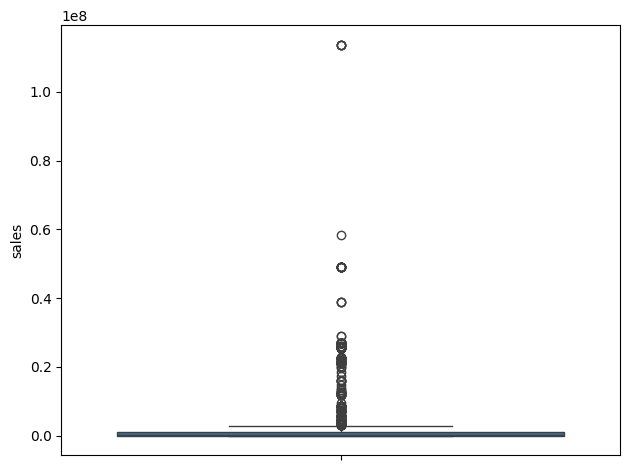

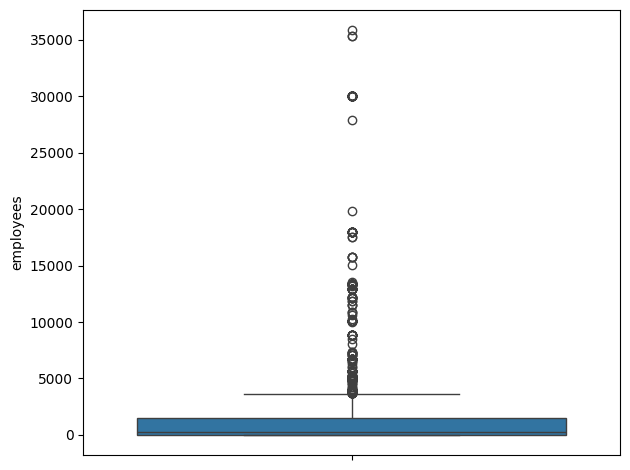

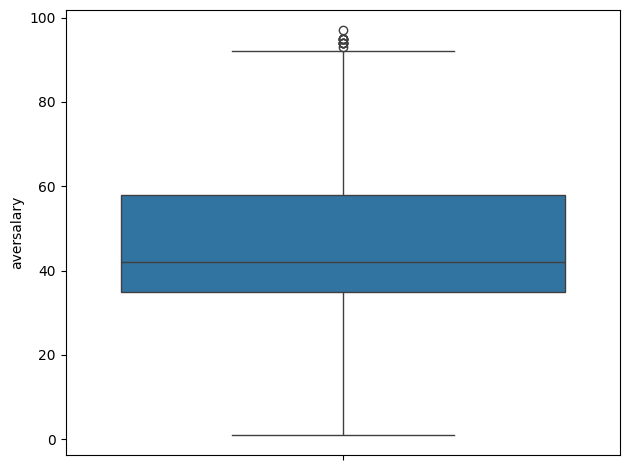

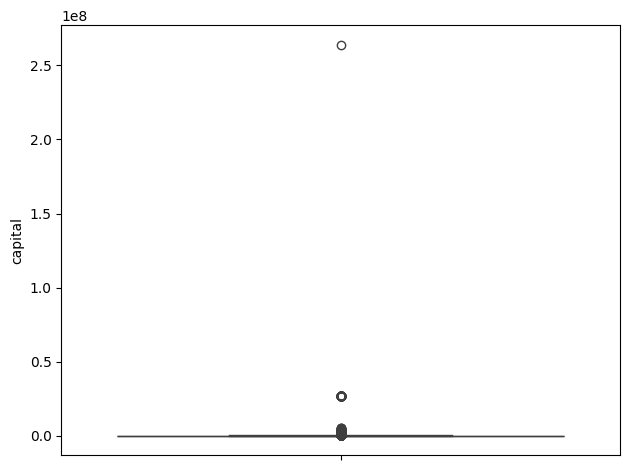

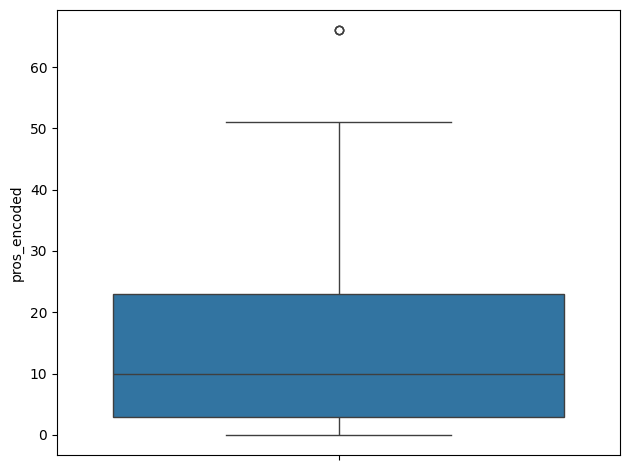

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['sales', 'employees','aversalary', 'capital', 'pros_encoded']

for col in numerical_cols:
    # sns.boxenplot(df[col])
    sns.boxplot(df[col])
    plt.tight_layout()
    plt.show()

In [20]:
# 최종적으로 채택되지는 않은 스케일링 방식
# scaler = StandardScaler()

# df.loc[:, 'sales': 'pros_encoded'] = scaler.fit_transform(df.loc[:, 'sales': 'pros_encoded'])
# df = df.round(4)

In [21]:
# 최종적으로 채택되지는 않은 스케일링 방식
# scaler = MinMaxScaler()

# df.loc[:, 'sales': 'pros_encoded'] = scaler.fit_transform(df.loc[:, 'sales': 'pros_encoded'])
# df = df.round(4)

In [22]:
# 최종적으로 채택
scaler = RobustScaler()

df.loc[:, 'sales': 'pros_encoded'] = scaler.fit_transform(df.loc[:, 'sales': 'pros_encoded'])
df = df.round(4)

print(df.describe())

            region    education      jobtype       cptype        sales  \
count  3015.000000  3015.000000  3015.000000  3015.000000  2253.000000   
mean      0.764842     0.836153     0.482587     0.670315     2.887175   
std       0.808932     1.170736     0.499780     0.817098     7.976932   
min       0.000000     0.000000     0.000000     0.000000    -0.130200   
25%       0.000000     0.000000     0.000000     0.000000    -0.125200   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     2.000000     1.000000     1.000000     0.874800   
max       2.000000     5.000000     1.000000     2.000000    95.856900   

         employees   aversalary      capital  pros_encoded  
count  2482.000000  2149.000000  2303.000000   3015.000000  
mean      1.121039     0.154087    24.992462      0.153018  
std       3.190629     0.750271   162.426437      0.609906  
min      -0.209200    -1.782600    -0.113000     -0.500000  
25%      -0.187600    -0.304

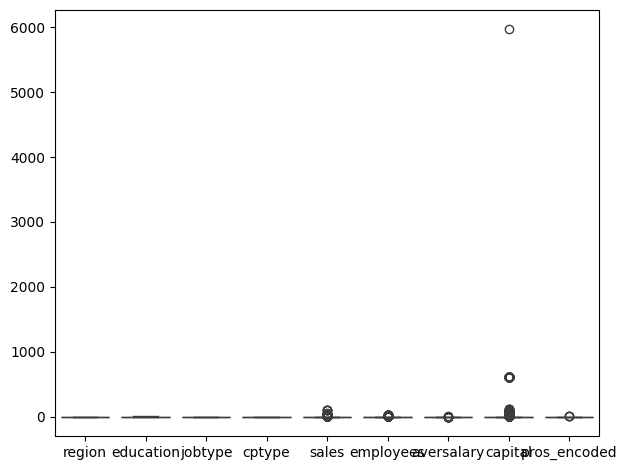

In [23]:
sns.boxplot(df)
plt.tight_layout()
plt.show()

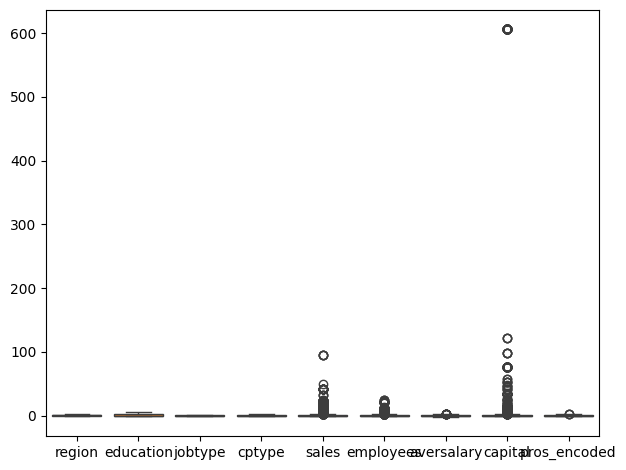

In [24]:
# 너무 극단적인 값 단 한 개 수동으로 제거
outlier = df[df['capital'] > 5000].index
df = df.drop(outlier, axis=0)

sns.boxplot(df)
plt.tight_layout()
plt.show()

In [25]:
df.to_csv('data.csv', encoding='utf-8-sig')

### UnderSampling

17개 행정구역마다 180개씩 행 데이터를 수집하여 {지방, 비수도권 광역시, 수도권} 으로 합친 결과  
수집한 데이터 (data.csv) 파일은 종속변수 분포가 불균형하게 되었다.  
모델 학습 과정 쓸 Balanced 한 데이터를 언더샘플링으로 만들고 이를 따로 data_balanced.csv 파일에 저장한다.  
샘플링되고 남은 데이터는 data_remaining.csv 파일에 저장한다.  

In [26]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)

### 클래스당 500 개씩으로 언더샘플링

In [27]:
print(df['region'].value_counts())

# num_samples = np.min(df['region'].value_counts())
num_samples = 500

class_0_sample = df[df['region'] == 0].sample(n=num_samples, replace=False, random_state=500)
class_1_sample = df[df['region'] == 1].sample(n=num_samples, replace=False, random_state=500)
class_2_sample = df[df['region'] == 2].sample(n=num_samples, replace=False, random_state=500)

class_0_remaining = df[df['region'] == 0].drop(class_0_sample.index)
class_1_remaining = df[df['region'] == 1].drop(class_1_sample.index)
class_2_remaining = df[df['region'] == 2].drop(class_2_sample.index)

df_balanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])
df_balanced.reset_index(drop=True, inplace=True)
df_balanced.to_csv('data_balanced.csv', encoding='utf-8-sig')

df_remaining = pd.concat([class_0_remaining, class_1_remaining, class_2_remaining])
df_remaining.reset_index(drop=True, inplace=True)
df_remaining.to_csv('data_remaining.csv', encoding='utf-8-sig')

region
0    1424
1     875
2     715
Name: count, dtype: int64


# 가설 1 검증  

가설 1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도 학습).  

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [30]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)
# undersampling 으로 선택된 행들. Train set 으로 사용
df_balanced = pd.read_csv('data_balanced.csv', encoding='utf-8-sig', index_col=0)
# 선택되지 않은 행들. Test set 으로 사용
df_remaining = pd.read_csv('data_remaining.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()

df_balanced_dropna = df_balanced.dropna()
df_remaining_dropna = df_remaining.dropna()

In [31]:
print(df_balanced['region'].value_counts()) # undersampling 적용되어 Balanced 한 상태
print(df_remaining['region'].value_counts()) # Imbalanced 하지만 학습에 쓸 데이터는 아니므로, class 별로 지표를 보기로 결정.

print(df_balanced_dropna['region'].value_counts()) # 약간 Imbalanced 하지만, 큰 차이는 아닌 것 같으므로 무시
print(df_remaining_dropna['region'].value_counts()) # Imbalanced 하지만 학습에 쓸 데이터는 아니므로, class 별로 지표를 보기로 결정.

region
0    500
1    500
2    500
Name: count, dtype: int64
region
0    924
1    375
2    215
Name: count, dtype: int64
region
2    300
0    288
1    242
Name: count, dtype: int64
region
0    492
1    198
2    132
Name: count, dtype: int64


In [32]:
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print()

region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
2 -> 수도권 : 서울, 인천, 세종, 경기

0 -> 1424 (0.4725)
1 -> 875 (0.2903)
2 -> 715 (0.2372)


### L2 규제 Logistic regression 모델, VIF & 상관계수 확인

가중치 감쇠를 통한 feature selection 발생여부 확인

Sales-Employees, Sales-capital 간의 양의 상관관계가 존재함을 확인

Accuracy : 0.4100
f1-score (macro) : 0.3902
Columns:  ['region' 'education' 'jobtype' 'cptype' 'sales' 'employees' 'aversalary'
 'capital' 'pros_encoded']
class  0
[-0.01221202 -0.03580703 -0.03447759  0.02253709 -0.14512778 -0.09110105
 -0.0023714   0.16543468]
class  1
[ 0.05638475 -0.16244023 -0.27186375  0.04126106  0.05205362 -0.04554344
 -0.01340529 -0.43481851]
class  2
[-0.04417273  0.19824726  0.30634134 -0.06379815  0.09307417  0.13664449
  0.01577669  0.26938383]


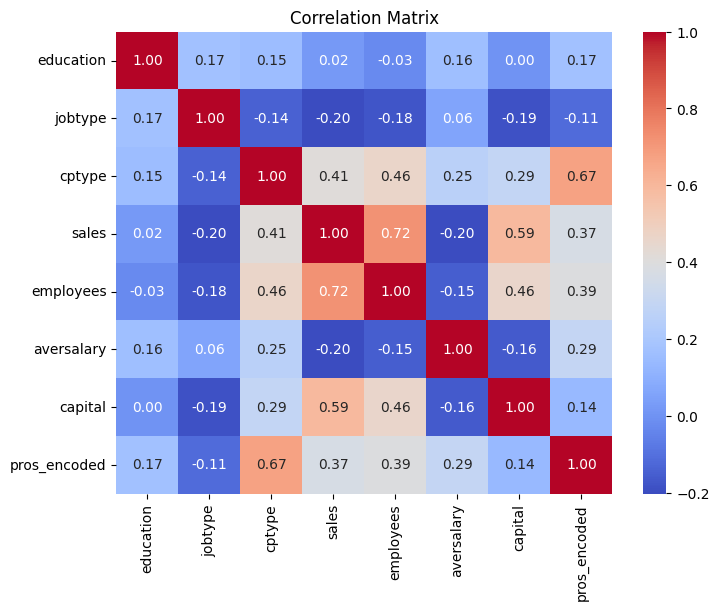

1.5949
1.6073
3.1204
3.7719
3.4178
1.6701
2.6787
2.3647


In [33]:
X_train = df_balanced_dropna.iloc[:, 1:]
y_train = df_balanced_dropna['region']

X_test = df_remaining_dropna.iloc[:, 1:]
y_test = df_remaining_dropna['region']

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

# Score
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

# feature selection -> sales, employees, capital
print("Columns: ", df.columns.values)
for i in range(len(linear.coef_)):
    print("class ", i)
    coef_set = linear.coef_[i]
    print(coef_set)

# Correlation matrix
correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# VIF
for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### 결측값이 존재하는 행 탐색

In [34]:
nan_rows = df.isna().any(axis=1)

df_nan = df[nan_rows]

print(df_nan.describe())

df_nan.head()

            region    education      jobtype       cptype       sales  \
count  1362.000000  1362.000000  1362.000000  1362.000000  600.000000   
mean      0.734949     0.780470     0.464023     0.461821    6.692517   
std       0.781545     1.153011     0.498887     0.769799   12.811688   
min       0.000000     0.000000     0.000000     0.000000   -0.130200   
25%       0.000000     0.000000     0.000000     0.000000   -0.127200   
50%       1.000000     0.000000     0.000000     0.000000    0.000000   
75%       1.000000     1.000000     1.000000     1.000000    5.933400   
max       2.000000     5.000000     1.000000     2.000000   95.856900   

        employees  aversalary    capital  pros_encoded  
count  829.000000  497.000000  650.00000   1362.000000  
mean     1.230340   -0.180477   68.75026     -0.095374  
std      4.171746    0.626951  188.54690      0.536237  
min     -0.209200   -1.521700   -0.11300     -0.500000  
25%     -0.203600   -0.565200   -0.11070     -0.500000  


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
2,2,0,0,0,95.8569,10.7799,0.8261,NaN,0.95
3,2,0,1,1,21.3606,12.3409,NaN,NaN,0.40
6,2,0,1,0,NaN,NaN,NaN,NaN,0.05
7,2,1,1,1,1.3717,0.8855,1.5652,NaN,0.60
13,2,0,1,2,0.3120,-0.0272,NaN,5.8862,1.00


<h5> 대부분의 결측값은 중소기업에 해당함을 확인 </h5>

In [35]:
print("지역에 따른 결측값 분포: \n", df_nan['region'].value_counts())
print("회사 규모에 따른 결측값 분포: \n", df_nan['cptype'].value_counts())


print ("\n region 값마다, 결측값이 존재하는 행 수 / 전체 행 수")
for cptype in [0, 1, 2]:
    print(f"cptype {cptype}")
    print(np.round(df_nan['region'].value_counts()[cptype] / df['region'].value_counts()[cptype], 2))

print ("\n cptype 값마다, 결측값이 존재하는 행 수 / 전체 행 수")
for cptype in [0, 1, 2]:
    print(f"cptype {cptype}")
    print(np.round(df_nan['cptype'].value_counts()[cptype] / df['cptype'].value_counts()[cptype], 2))

지역에 따른 결측값 분포: 
 region
0    644
1    435
2    283
Name: count, dtype: int64
회사 규모에 따른 결측값 분포: 
 cptype
0    967
2    234
1    161
Name: count, dtype: int64

 region 값마다, 결측값이 존재하는 행 수 / 전체 행 수
cptype 0
0.45
cptype 1
0.5
cptype 2
0.4

 cptype 값마다, 결측값이 존재하는 행 수 / 전체 행 수
cptype 0
0.58
cptype 1
0.24
cptype 2
0.35


### Xgboost classifier


### Balanced dataset (undersampling) - No drop na  

결측값에도 필요한 정보가 존재할 수 있다고 생각되므로 단순히 drop 처리하기 껄끄럽다,    
결측값에 대한 별도 처리가 필요없는 Xgboost Classifier 모델을 사용이 적절하다고 판단된다.    

확인된 상관관계는 xgboost 알고리즘 특성상 모델 성능에 영향이 미미할 것이라 간주하고 이에 대한 처리를 수행하지 않았다.

In [36]:
X_train = df_balanced.iloc[:, 1:]
y_train = df_balanced['region']

X_test = df_remaining.iloc[:, 1:]
y_test = df_remaining['region']

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective="multi:softmax",
    num_class=3,
    eval_metric=["mlogloss"],
)

xgb_clf.fit(
    X_train,
    y_train,
    verbose=0,  # set to 1 to see xgb training round intermediate results
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

y_pred = xgb_clf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

accuracy: 0.4478
f1-score (macro) : 0.4334


### 예측결과에 대한 Confusion matrix  

testset 은 imbalanced 한 상태이므로, class 마다의 평가지표를 보기로 결정.

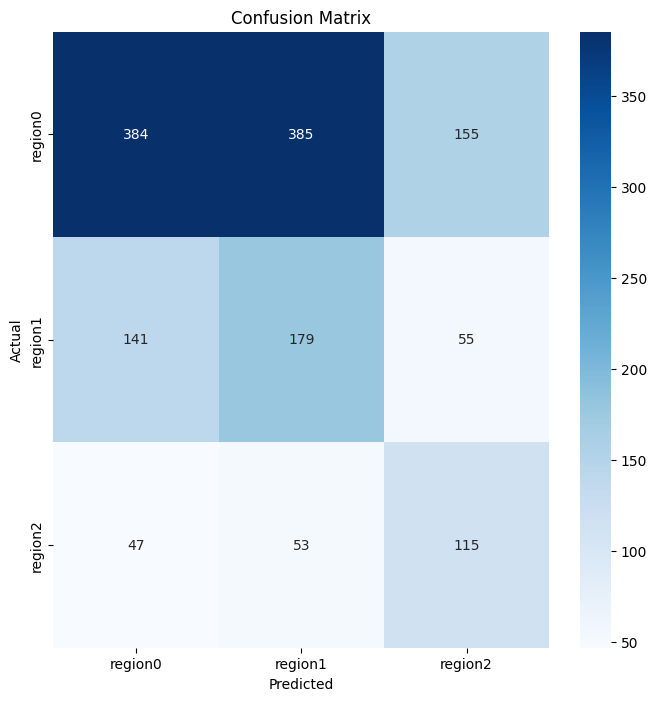

f1_score of class 0 : 0.51
recall_score of class 0 : 0.42
precision_score of class 0 : 0.67

f1_score of class 1 : 0.36
recall_score of class 1 : 0.48
precision_score of class 1 : 0.29

f1_score of class 2 : 0.43
recall_score of class 2 : 0.53
precision_score of class 2 : 0.35

accuracy: 0.4478
f1-score (macro) : 0.4334


In [37]:
cm = confusion_matrix(y_test, y_pred)

target_classes = ['region0', 'region1', 'region2']

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_classes, 
            yticklabels=target_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1_scores = f1_score(y_true=y_test, y_pred=y_pred, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

### Balanced dataset (undersampling) , 결측값 drop 시

region 0 에 대해서만 f1-score 증가.

drop 하면서 제거된 행데이터들의 분포는 주로 region 0 (지방), cptype 0 (중소기업) 이었다.  
성능은 소폭 증가했지만, 정보손실을 우려하여 dropna 하지 않기로 결정  

In [38]:
X_train = df_balanced_dropna.iloc[:, 1:]
y_train = df_balanced_dropna['region']

X_test = df_remaining_dropna.iloc[:, 1:]
y_test = df_remaining_dropna['region']

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective="multi:softmax",
    num_class=3,
    eval_metric=["mlogloss"],
)

xgb_clf.fit(
    X_train,
    y_train,
    verbose=0,  # set to 1 to see xgb training round intermediate results
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

y_pred = xgb_clf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

accuracy: 0.5085
f1-score (macro) : 0.4689


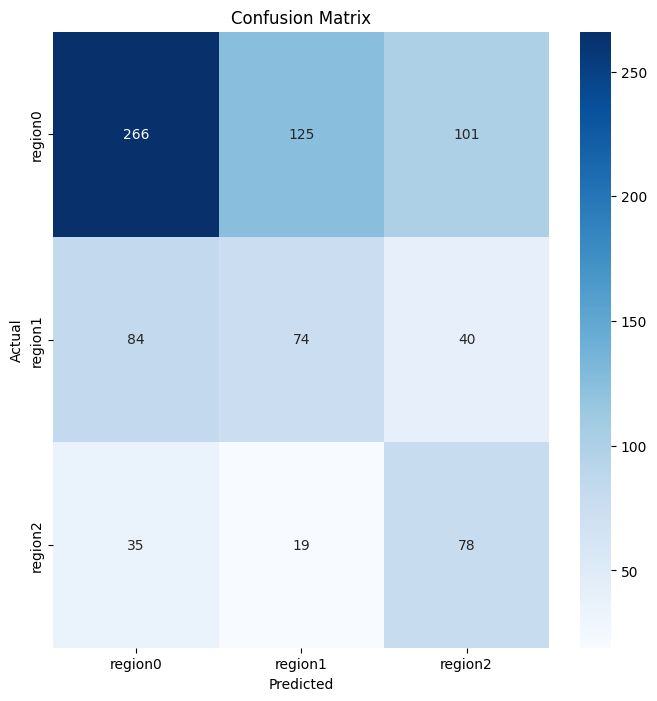

f1_score of class 0 : 0.61
recall_score of class 0 : 0.54
precision_score of class 0 : 0.69

f1_score of class 1 : 0.36
recall_score of class 1 : 0.37
precision_score of class 1 : 0.34

f1_score of class 2 : 0.44
recall_score of class 2 : 0.59
precision_score of class 2 : 0.36

accuracy: 0.5085
f1-score (macro) : 0.4689


In [39]:
cm = confusion_matrix(y_test, y_pred)

target_classes = ['region0', 'region1', 'region2']

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_classes, 
            yticklabels=target_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1_scores = f1_score(y_true=y_test, y_pred=y_pred, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

### 최종 모델에 사용할 데이터셋 확정  
Train set :  (balanced)  
data_balanced.csv 파일의 데이터. data.csv 파일에서 Undersampling, dropna X  

Test set :  (imbalanced)  
data_remaining.csv 파일의 데이터. data.csv 파일에서 Train set 을 추출하고 남은 데이터. dropna X

실제 real world 데이터는 수집한 데이터 data.csv 와 달리 region 2 값이 다수이다.  

real world 데이터 분포와 동일한 분포의 테스트 데이터를 준비하진 않고,  
각 class 마다 f1-score 와 precision, recall 지표를 보는 것으로 타협하였다.  

In [40]:
X_train = df_balanced.iloc[:, 1:]
y_train = df_balanced['region']

X_test = df_remaining.iloc[:, 1:]
y_test = df_remaining['region']

# df_remaining['region'].value_counts()

# test_c0 = df_remaining[df_remaining['region'] == 0].sample(n=200, replace=False, random_state=222)
# test_c1 = df_remaining[df_remaining['region'] == 1].sample(n=200, replace=False, random_state=222)
# test_c2 = df_remaining[df_remaining['region'] == 2].sample(n=200, replace=False, random_state=222)

# df_remaining_balanced = pd.concat([test_c0, test_c1, test_c2])
# df_remaining_balanced.reset_index(drop=True, inplace=True)

# X_test = df_remaining_balanced.iloc[:, 1:]
# y_test = df_remaining_balanced['region']

In [41]:
print(df_balanced['region'].value_counts())
print(df_remaining['region'].value_counts())

region
0    500
1    500
2    500
Name: count, dtype: int64
region
0    924
1    375
2    215
Name: count, dtype: int64


### 하이퍼 파라미터 튜닝

아래 코드 실행시 결과  
Best Parameters:  {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 0.76}  
Best Score:  0.48266666666666663

In [42]:
# param_dist = {
#     'n_estimators' : np.arange(10, 210, 10),
#     'learning_rate' : np.arange(0, 1, 0.02),
#     'max_depth' : np.arange(1, 5),
# }

# xgb_clf = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric=['mlogloss'],)


# xgb_clf_tuned = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=100, random_state=4885, cv=3)

# xgb_clf_tuned.fit(X_train, y_train)

# print("Best Parameters: ", xgb_clf_tuned.best_params_)
# print("Best Score: ", xgb_clf_tuned.best_score_)

### 튜닝된 모델로 예측 및 예측결과 시각화  

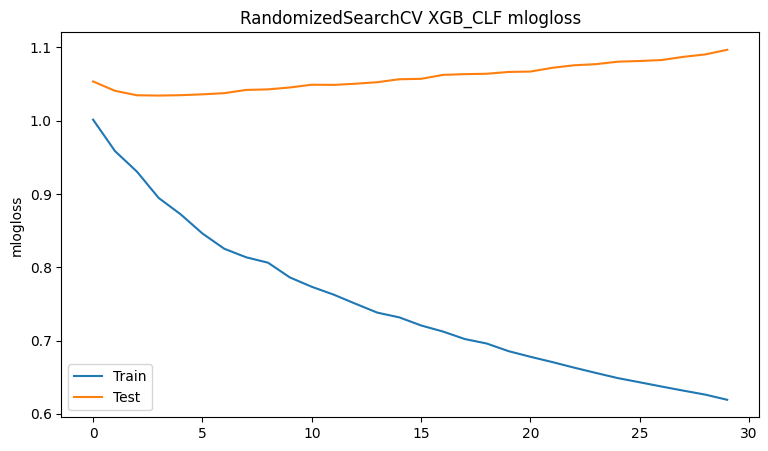

acc: 0.4703
f1-score (macro) : 0.4534

f1_score of class 0 : 0.53
recall_score of class 0 : 0.43
precision_score of class 0 : 0.71

f1_score of class 1 : 0.40
recall_score of class 1 : 0.50
precision_score of class 1 : 0.33

f1_score of class 2 : 0.43
recall_score of class 2 : 0.59
precision_score of class 2 : 0.34



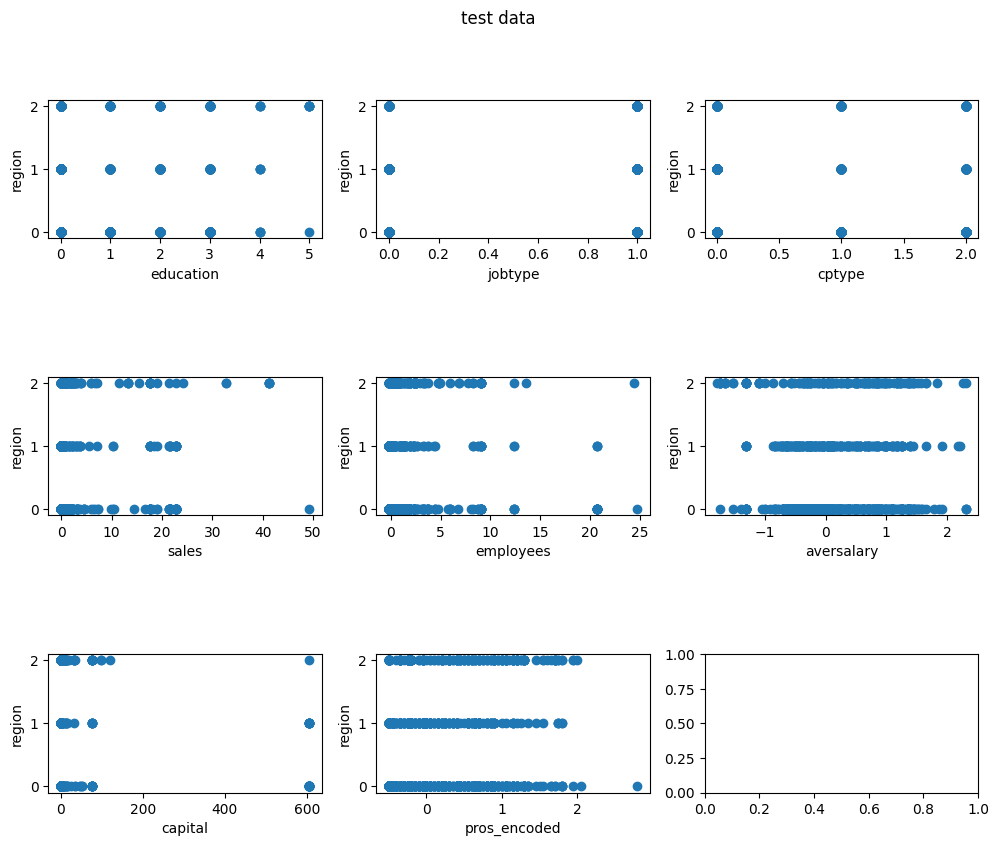

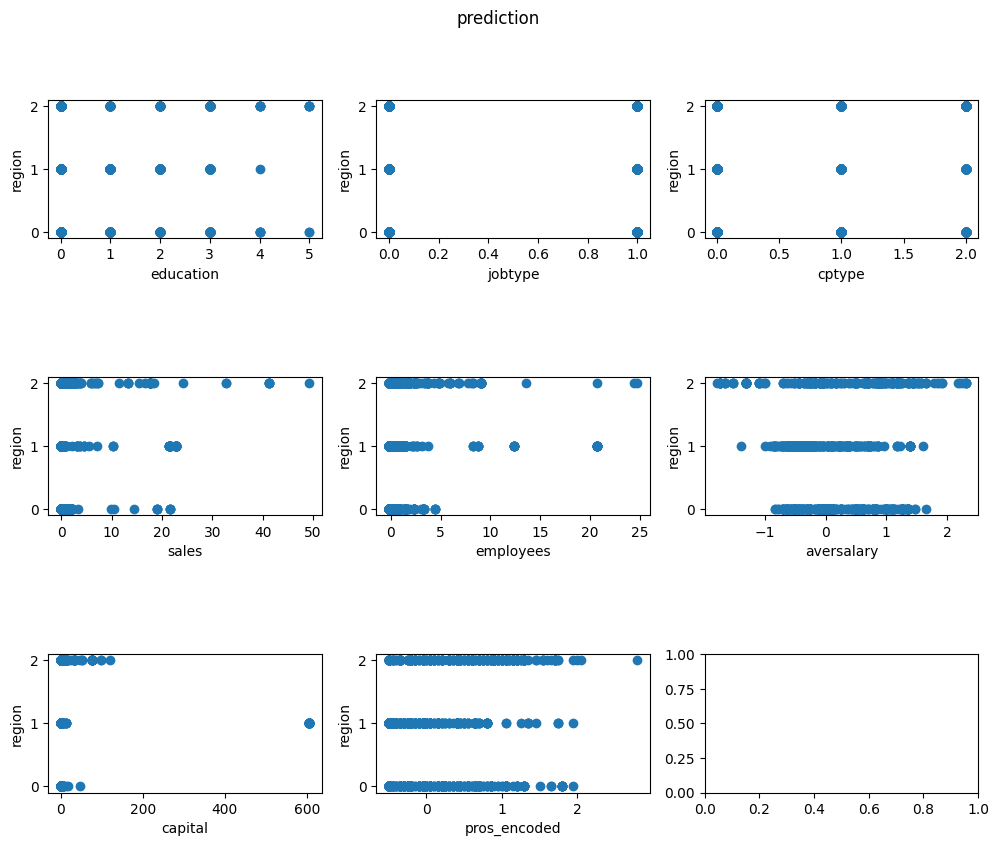

In [43]:
# best_params : {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 0.76}

xgb_clf_tuned = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    eval_metric=['mlogloss'],
    n_estimators = 30,
    max_depth = 4,
    learning_rate = 0.76,
    )

xgb_clf_tuned.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# ----- 학습 epoch 당 모델 score (여기서는 mlogloss) 변화 시각화 -----
results = xgb_clf_tuned.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('RandomizedSearchCV XGB_CLF mlogloss')
plt.show()

y_pred = xgb_clf_tuned.predict(X_test)

print(f"acc: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

f1_scores = f1_score(y_true=y_test, y_pred=y_pred, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred, average=None)

print()
for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

# ----- X_test - y_test 산점도 -----
features = df.columns[1:]

fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(12, 9))

fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_test)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])
    axes[axe_row, axe_col].set_ylabel('region')
plt.suptitle("test data")
plt.show()

# ----- X_test - y_pred 산점도 -----
fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(12, 9))
fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_pred)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])
    axes[axe_row, axe_col].set_ylabel('region')

plt.suptitle("prediction")
plt.show()

### 최종 분류 모델의 예측결과에 대한 혼동 행렬  
현재 조건에서는 region 2 에 대한 예측성능이 나머지 region 0, 1 에 대한 예측성능보다 약간 높으며  
나머지 둘은 비슷하다.

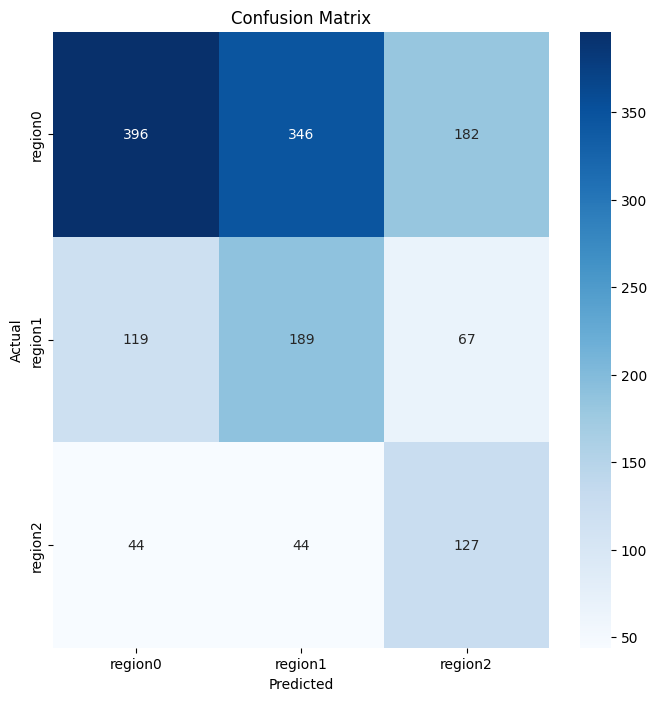

f1_score of class 0 : 0.53
recall_score of class 0 : 0.43
precision_score of class 0 : 0.71

f1_score of class 1 : 0.40
recall_score of class 1 : 0.50
precision_score of class 1 : 0.33

f1_score of class 2 : 0.43
recall_score of class 2 : 0.59
precision_score of class 2 : 0.34

accuracy: 0.4703
f1-score (macro) : 0.4534


In [44]:
cm = confusion_matrix(y_test, y_pred)

target_classes = ['region0', 'region1', 'region2']

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_classes, 
            yticklabels=target_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1_scores = f1_score(y_true=y_test, y_pred=y_pred, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

In [45]:
from xgboost import plot_tree

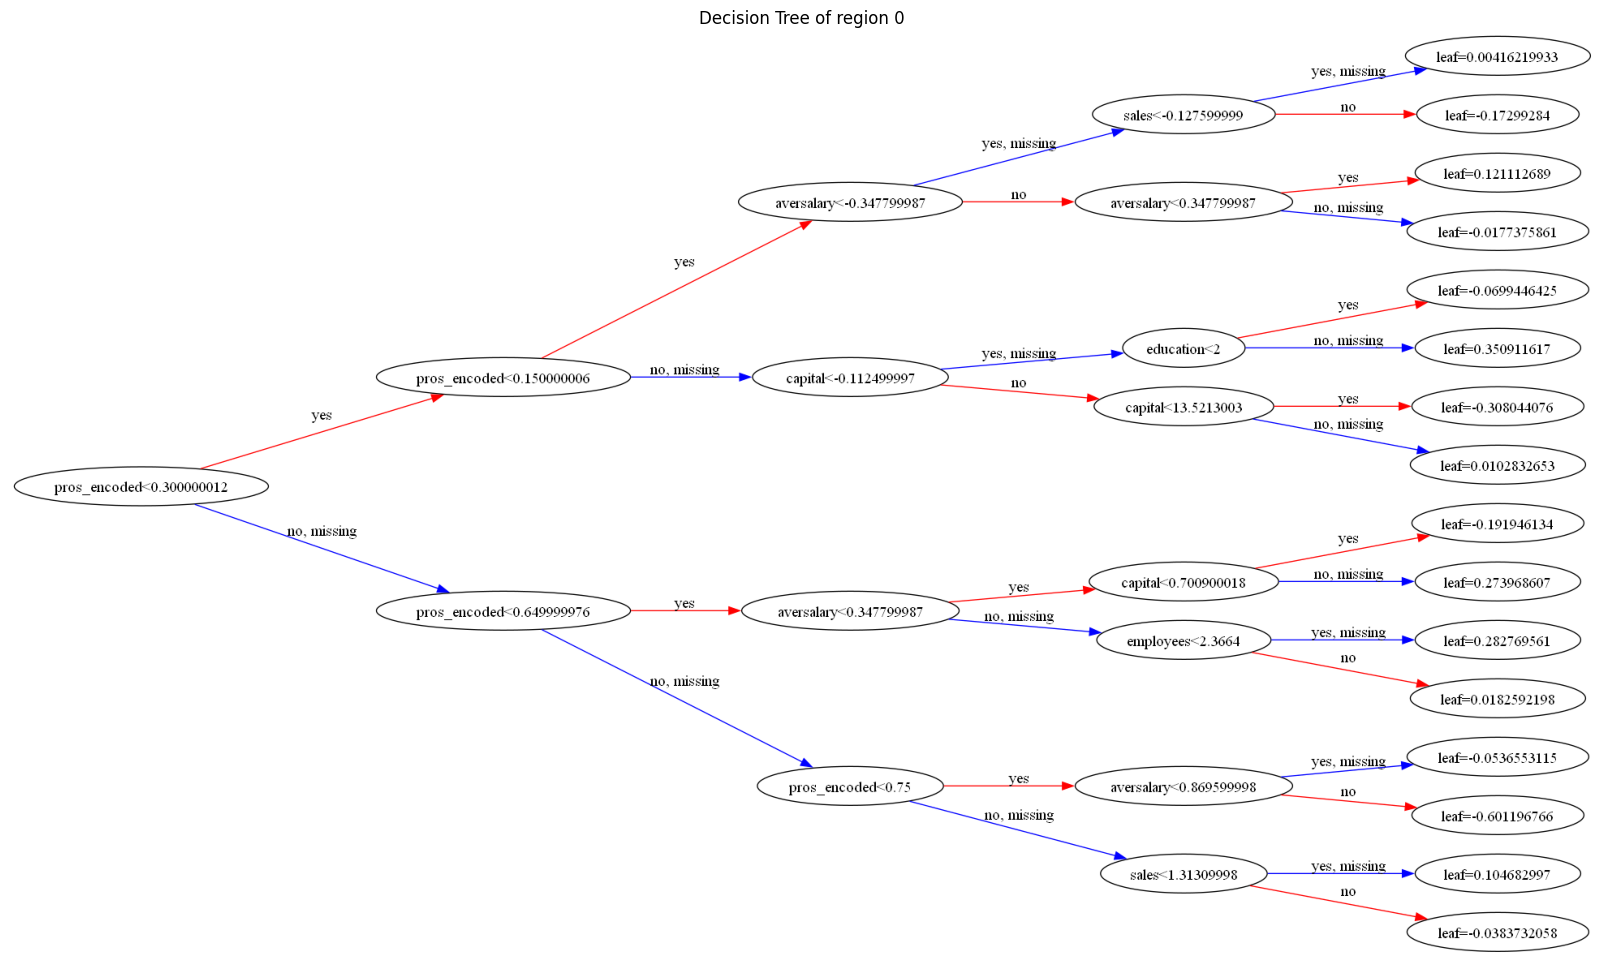

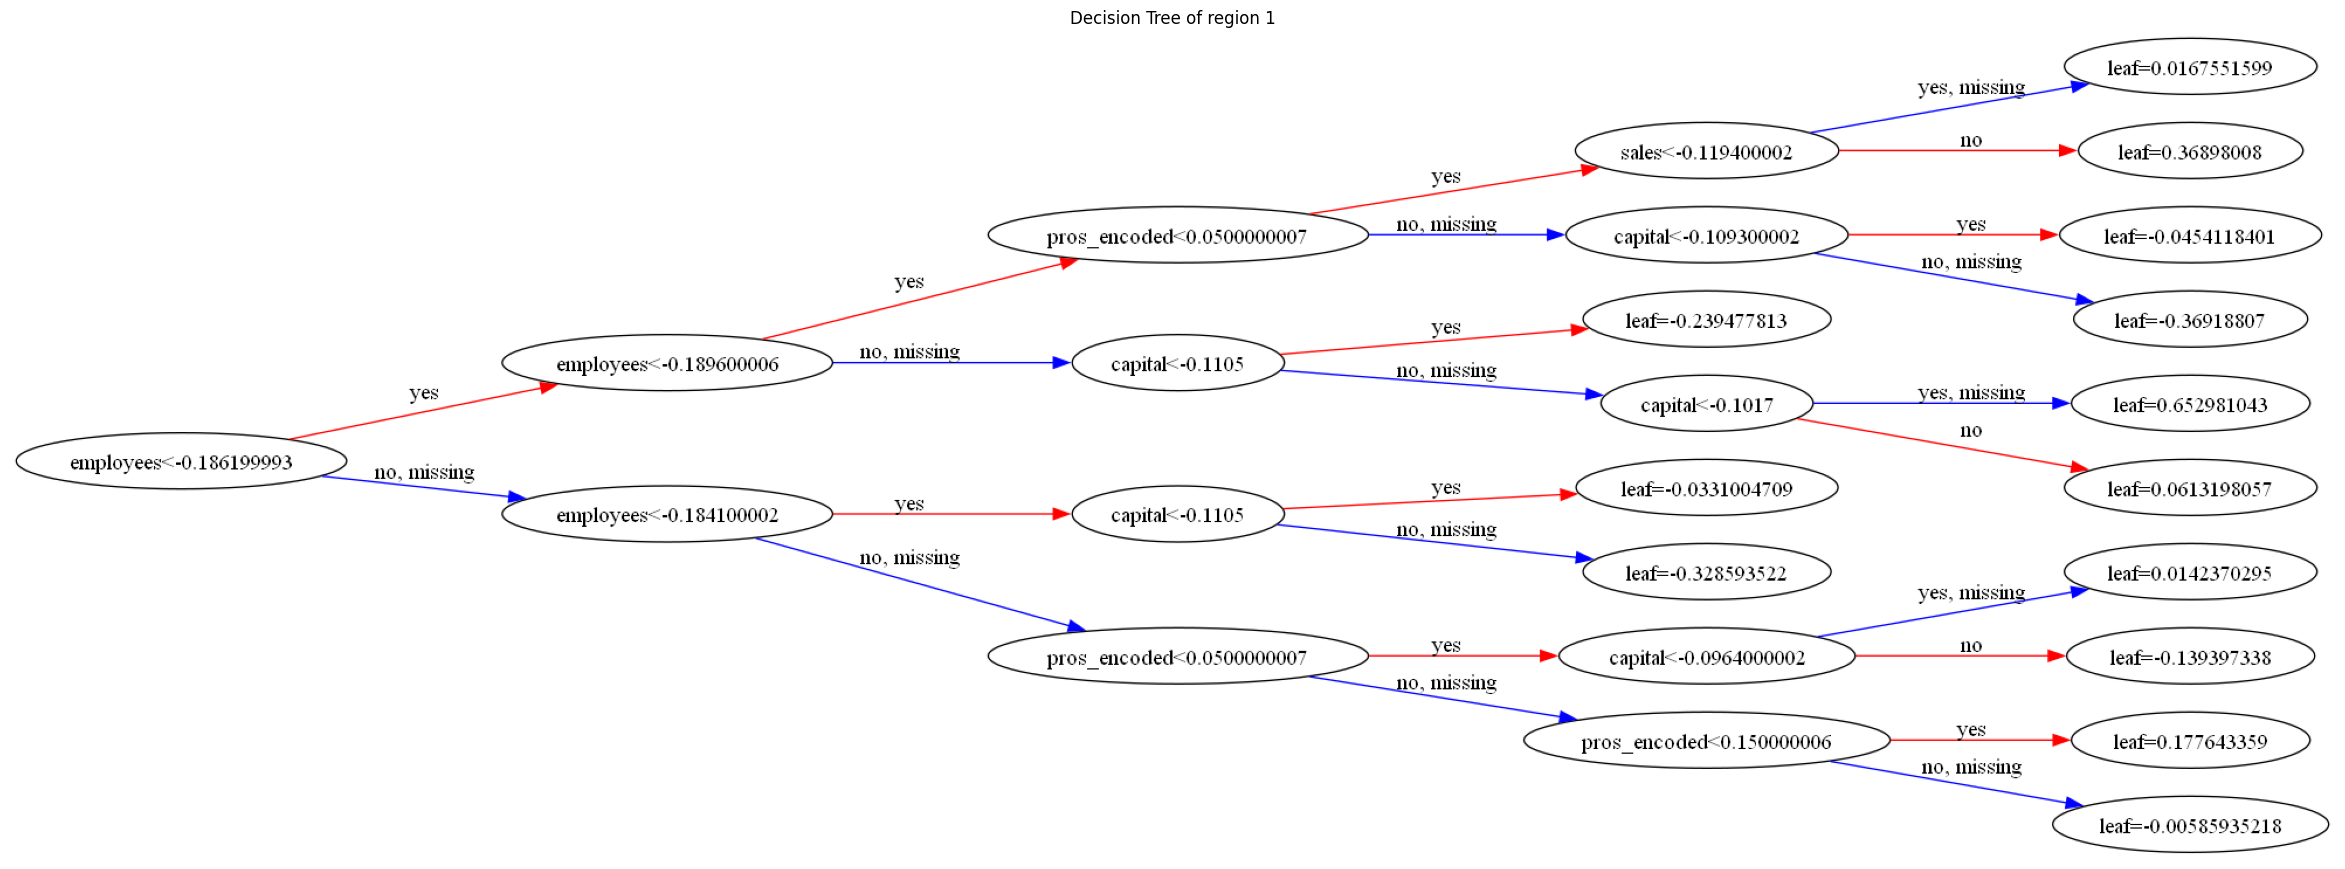

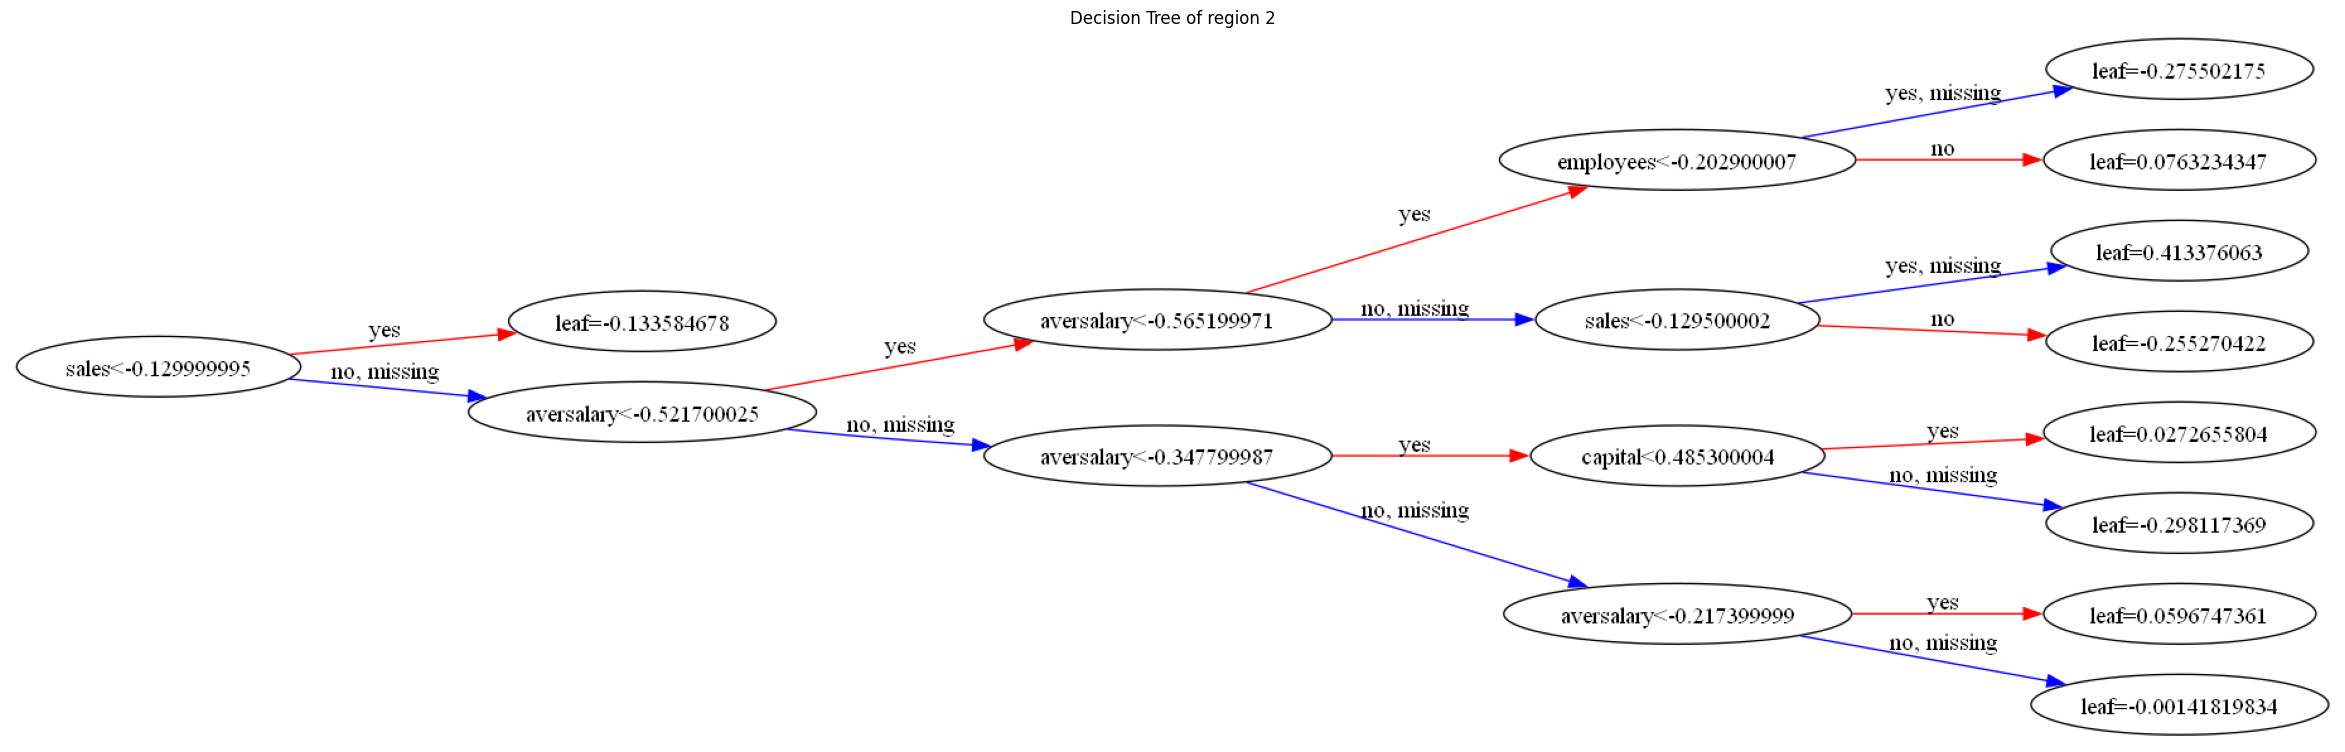

In [46]:
# best_params
# {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 0.76}

for class_region in [0, 1, 2]:
    # num_tree 는 best_params 에 맞춰 하드 코딩된 값
    num_tree = (class_region * 30) + 29

    # rankdir="LR" : 왼쪽에서 오른쪽 방향으로 트리를 보여준다.
    plot_tree(xgb_clf_tuned, num_trees=num_tree, rankdir='LR')
    fig = plt.gcf()
    fig.set_size_inches(30, 12)

    # 이미지 저장
    fig.savefig(f'tree_class{class_region}.png')

    plt.title(f'Decision Tree of region {class_region}')
    plt.show()

### 최종 분류 모델의 Feature importance

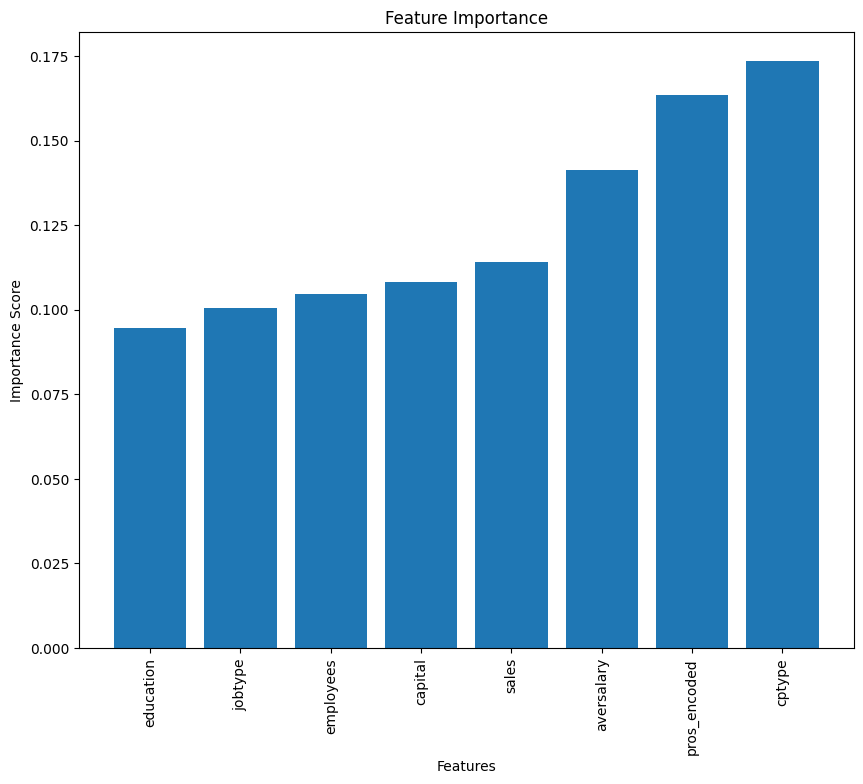

In [47]:
feature_importance = xgb_clf_tuned.feature_importances_
# 오름차순 정렬 시 인덱스
sorted_idx = np.argsort(feature_importance)

X = df.iloc[:, 1:]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

결측값이 존재하는 상태 (종속변수에는 결측값이 존재하지 않는다.) 에서 언더샘플링 한 데이터를 모델학습에 사용하였다.  
또한, 결측값을 포함해 학습하기 위해 xgboost 사용하였다.  

해당 모델을 사용하여 '구인 공고에 등록된 정보' 를 가지고 '구인 공고가 올라온 지역' 을 예측한 결과는 다음과 같았다.    

accuracy: 0.4703  
f1-score (macro) : 0.4534  

사용한 데스트 데이터 분포는  
{  
    '0': 924(0.6103),  
    '1': 375(0.2477),  
    '2' 215(0.1420),  
}  

무작위 예측 모델 성능은  
accuracy: 0.4604  
f1-score (macro) : 0.3332  

무조건 '지방 지역' 으로 예측하는 모델 성능은  
accuracy: 0.6103  
f1-score (macro) : 0.2527  

f1-score 상으로, 무작위 예측이나 무조건 다수 클래스로 예측하는 모델에 비해 성능이 약간 높지만 유의미한 성능이라고는 생각되지 않는다.  

#### 따라서 < 1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도학습). > 는 틀렸다고 판단된다.  

In [48]:
print(df_balanced['region'].value_counts()) # train set
print(df_remaining['region'].value_counts()) # test set

for i in [0, 1, 2]:
    print(np.round(df_remaining['region'].value_counts()[i] / df_remaining['region'].value_counts().sum(), 4))

region
0    500
1    500
2    500
Name: count, dtype: int64
region
0    924
1    375
2    215
Name: count, dtype: int64
0.6103
0.2477
0.142


### 오직 다수 클래스로만 예측하는 모델의 성능

In [49]:
y_pred_only0 = [0] * len(df_remaining)

f1_scores = f1_score(y_true=y_test, y_pred=y_pred_only0, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred_only0, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred_only0, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred_only0):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred_only0, average='macro'):.4f}")

f1_score of class 0 : 0.76
recall_score of class 0 : 1.00
precision_score of class 0 : 0.61

f1_score of class 1 : 0.00
recall_score of class 1 : 0.00
precision_score of class 1 : 0.00

f1_score of class 2 : 0.00
recall_score of class 2 : 0.00
precision_score of class 2 : 0.00

accuracy: 0.6103
f1-score (macro) : 0.2527


d:\anaconda3\envs\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 랜덤으로 예측하는 모델의 성능

In [50]:
y_pred_random = [np.random.choice([0, 1, 2], p=[0.6103, 0.2477, 0.142]) for _ in range(len(df_remaining))]

f1_scores = f1_score(y_true=y_test, y_pred=y_pred_random, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred_random, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred_random, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred_random):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred_random, average='macro'):.4f}")

f1_score of class 0 : 0.62
recall_score of class 0 : 0.62
precision_score of class 0 : 0.61

f1_score of class 1 : 0.25
recall_score of class 1 : 0.25
precision_score of class 1 : 0.26

f1_score of class 2 : 0.17
recall_score of class 2 : 0.17
precision_score of class 2 : 0.18

accuracy: 0.4663
f1-score (macro) : 0.3480


## 가설 검정  
검정 과정 이전에 결측값 처리가 필요하므로, 모델학습에 사용한 것과 달리 결측값은 모두 drop 처리하였다.

['region' 'education' 'jobtype' 'cptype' 'sales' 'employees' 'aversalary'
 'capital' 'pros_encoded']
region
0    1424
1     876
2     715
Name: count, dtype: int64
num_region0 (dropna) :  780
num_region1 (dropna) :  440
num_region2 (dropna) :  432


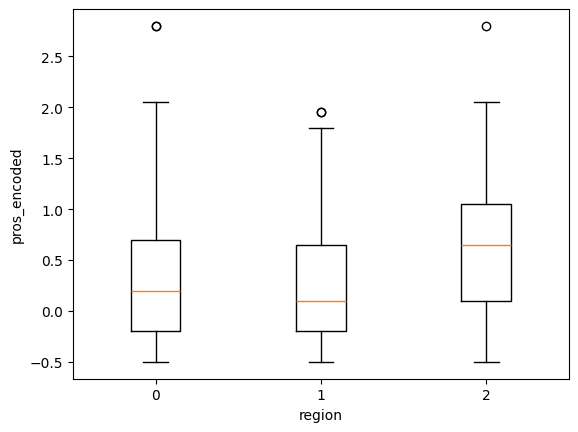

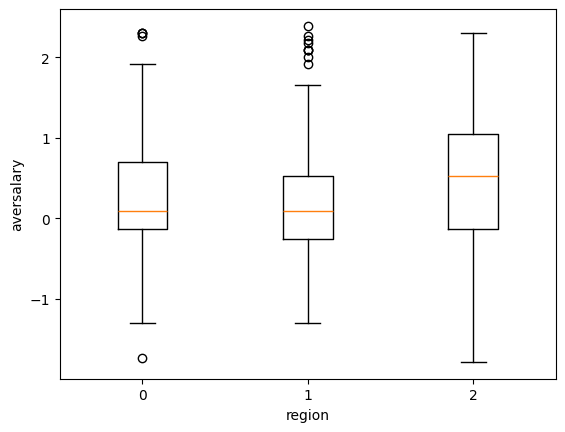

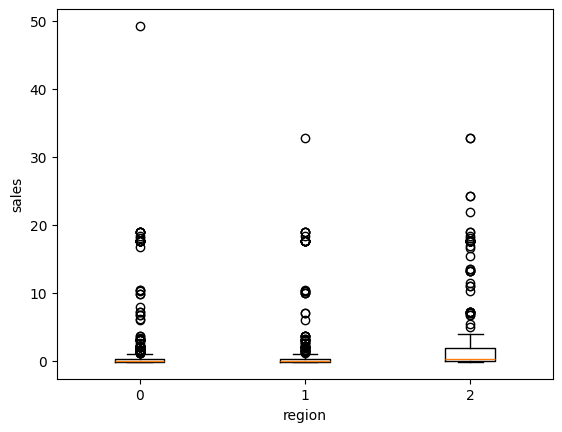

In [51]:
df = pd.read_csv('data_beforeScaling.csv', encoding='utf-8-sig', index_col=0)

print(df.columns.values)
print(df['region'].value_counts())

region_0 = df_dropna[df_dropna['region'] == 0]
region_1 = df_dropna[df_dropna['region'] == 1]
region_2 = df_dropna[df_dropna['region'] == 2]

print("num_region0 (dropna) : ", len(region_0))
print("num_region1 (dropna) : ", len(region_1))
print("num_region2 (dropna) : ", len(region_2))

# 튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric type 항목
features = ['pros_encoded', 'aversalary', 'sales']

for feature in features:
    plot_data = [region_0[feature], region_1[feature], region_2[feature]]
    ax = plt.boxplot(plot_data, labels=[0, 1, 2])
    plt.xlabel("region")
    plt.ylabel(feature)
    plt.show()

### ONE-WAY ANOVA TEST

튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric 피쳐  
['pros_encoded', 'aversalary', 'sales'] 에 대해 One-way ANOVA 검정 수행  

표본평균이 통계적으로 유의미한 수준으로 차이남을 확인  

정규성은 만족하지 않으나, bartlett's test 를 통해 등분산성 확인.  
ref. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett

정규성은 만족하지 않으나, 비모수 검정보다 모수 검정이 더 유효하다고 판단  
중심 극한 정리에 의해 정규성을 따르지 않더라도 모수적 검정이 가능하다는 글을 참고하였다.  
ref 1. https://blog.minitab.com/ko/adventures-in-statistics-2/choosing-between-a-nonparametric-test-and-a-parametric-test  
ref 2. https://statisticsbyjim.com/hypothesis-testing/nonparametric-parametric-tests/

In [52]:
from scipy import stats

In [53]:
features = ['pros_encoded', 'aversalary', 'sales']

print("정규성 만족 확인")
# pvalue > 0.05 이상이면 정규성 만족
for feature in features:
    print(feature)
    print(f"{stats.shapiro(region_0[feature]).pvalue:.8f}")
    print(f"{stats.shapiro(region_1[feature]).pvalue:.8f}")
    print(f"{stats.shapiro(region_2[feature]).pvalue:.8f}")

# 등분산성 확인
print("\n등분산성 확인 (bartlett's test)")
for feature in features:
    print(feature)
    # 통상적인 유의수준 0.05 (5%) 보다 낮으므로 각 집단 분산이 다르다.
    # The very small p-value suggests that the populations do not have equal variances.
    # ref. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett
    
    print(f"{stats.bartlett(region_0[feature], region_1[feature], region_2[feature]).pvalue:.8f}")

print("\none-way ANOVA")
for feature in features:
    print(feature)
    print(stats.f_oneway(region_0[feature], region_1[feature], region_2[feature]))

정규성 만족 확인
pros_encoded
0.00000000
0.00000000
0.00000408
aversalary
0.00000000
0.00000070
0.00000000
sales
0.00000000
0.00000000
0.00000000

등분산성 확인 (bartlett's test)
pros_encoded
0.02996645
aversalary
0.00000000
sales
0.00000000

one-way ANOVA
pros_encoded
F_onewayResult(statistic=54.41740370023298, pvalue=1.3002302415233098e-23)
aversalary
F_onewayResult(statistic=5.923864490850419, pvalue=0.002732099281766318)
sales
F_onewayResult(statistic=26.510482132875524, pvalue=4.654428013528492e-12)


### ANOVA test 후 사후 검정

지역마다 아래 3개 피쳐의 표본평균값에대해 유의미한 차이가 존재하는지 분석해보았다.  
아래 3개 피쳐는 수치형 데이터 타입 피쳐 중에서 최종 모델의 피쳐 중요도 상위 3 개 피쳐로 선정하였다.

<검정 결과>  
[pros_encoded]  

지역마다 통계적으로 유의미한 수준으로 차이난다.

[aversalary]  

(지방 - 비수도권 광역시), (지방 - 수도권) 의 차이는 무의미하다. 비수도권 광역시-수도권 의 차이는 유의미하다.  

[sales]  

(지방 - 비수도권 광역시) 사이는 무의미, (지방 - 수도권) 과 (비수도권 - 수도권) 사이는 유의미한 차이 존재.

In [54]:
import scikit_posthocs as sp

print("### scheffe's test ###")

features = ['pros_encoded', 'aversalary', 'sales']

for feature in features:
    x = pd.DataFrame({'0':region_0[feature].reset_index(drop=True), 
                      '1':region_1[feature].reset_index(drop=True), 
                      '2':region_2[feature].reset_index(drop=True)})

    x = x.melt(var_name='region', value_name=feature)

    x = x.dropna() # 지역마다 표본 수 동일

    # scheffe's test
    print("\n",feature)
    print(sp.posthoc_scheffe(x, val_col=feature, group_col='region'))

### scheffe's test ###

 pros_encoded
              0             1             2
0  1.000000e+00  1.517594e-02  1.938339e-15
1  1.517594e-02  1.000000e+00  1.842321e-21
2  1.938339e-15  1.842321e-21  1.000000e+00

 aversalary
          0         1         2
0  1.000000  0.197021  0.112832
1  0.197021  1.000000  0.002767
2  0.112832  0.002767  1.000000

 sales
              0             1             2
0  1.000000e+00  7.289679e-01  2.459122e-11
1  7.289679e-01  1.000000e+00  2.556473e-07
2  2.459122e-11  2.556473e-07  1.000000e+00


# 가설 2 & 3 검증

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

### 사용할 데이터

xgboostClassifier 모델 학습 때 사용한 데이터와 클러스터링에 사용할 데이터가 약간 차이가 있다.  
전자는 dropna 를 하지 않고 각 클래스별로 500개씩,  
후자는 dropna 처리 후 각 클래스별로 400개를 샘플링하였다.  

In [56]:
# 전체 데이터셋. 결측값 포함, 불균형 Imbalanced
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()

print(df_dropna['region'].value_counts())

class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

# 결측값 drop. Balanced
df_balanced_dropna = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_balanced_dropna.reset_index(drop=True, inplace=True)

print(df_balanced_dropna['region'].value_counts())

region
0    780
1    440
2    432
Name: count, dtype: int64
region
0    400
1    400
2    400
Name: count, dtype: int64


## 가설 2 검증  

### 단순 시각화 - 지역별 구인공고를 내건 기업의 규모 (중소(0), 중견(1), 대기업(1)) 비율  
### 가설 2 의 참/거짓을 확인하기 위해 수집한 데이터 분포를 시각화  

[가설 2]  
{수도권, 비수도권 광역시, 그 외 지방} 지역 중에서,  
<수도권> 지역이 '대기업 및 중견기업이 내건 구인공고 비중'이 가장 크고 <그 외 지방> 지역이 해당 공고 비중이 가정 작을 것이다.  

확인 결과,  
예상대로 <수도권>은 다른 두 지역에 비해 대기업 및 중견기업 비율이 가장 컸다.  
또한,  
예상과 달리 <비수도권 광역시> 지역이 <지방> 지역보다 대기업 및 중견기업 비율이 더 작았다.  

#### 즉, 가설 2의 일부분만 예상대로였다.

cptype
0    0.58
1    0.23
2    0.19
Name: count, dtype: float64
cptype
0    0.65
1    0.18
2    0.18
Name: count, dtype: float64
cptype
0    0.38
2    0.35
1    0.27
Name: count, dtype: float64


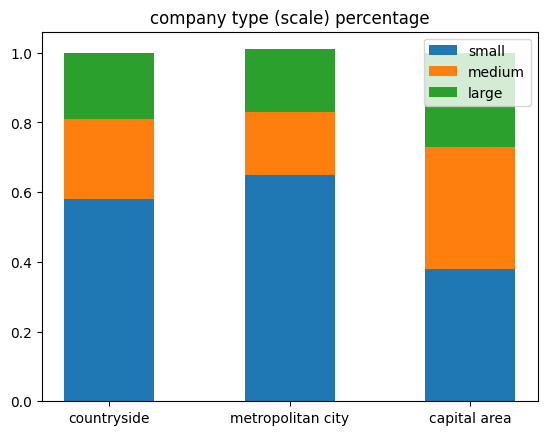

In [57]:
region_0 = df[df["region"] == 0]
region_1 = df[df["region"] == 1]
region_2 = df[df["region"] == 2]

region_0_total = region_0.shape[0]
region_1_total = region_1.shape[0]
region_2_total = region_2.shape[0]

region_0_percentages = np.round(region_0["cptype"].value_counts() / region_0_total, 2)
region_1_percentages = np.round(region_1["cptype"].value_counts() / region_1_total, 2)
region_2_percentages = np.round(region_2["cptype"].value_counts() / region_2_total, 2)

print(region_0_percentages)
print(region_1_percentages)
print(region_2_percentages)

regions = (
    "countryside",
    "metropolitan city",
    "capital area",
)

x = pd.DataFrame(
    {
        "0": region_0_percentages.values,
        "1": region_1_percentages.values,
        "2": region_2_percentages.values,
    }
)

weight_counts = {
    "small": x.iloc[0].values,
    "medium": x.iloc[1].values,
    "large": x.iloc[2].values,
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for cptype, weight_count in weight_counts.items():
    p = ax.bar(regions, weight_count, width, label=cptype, bottom=bottom)
    bottom += weight_count

ax.set_title("company type (scale) percentage")
ax.legend(loc="upper right")

plt.show()


## 가설 3 검증

[가설 3]  
구인 공고 데이터 피쳐를 바탕으로 클러스터링 시에  
크게 그룹 {우수한 일자리 / 중간 / 상대적으로 별로인 일자리} 로  나눌  수 있을 것이며,  
수도권에 가까울수록 우수한 일자리 그룹에 소속된 데이터포인트가 다수일 것이다. (비지도 학습)

만약 가설 3이 사실로 검증된다면, 수집한 데이터가 일자리의 질적 평가를 내릴 수 있을 만큼의 정보량을 가지고 있다는 의미일 것이다.

## k-means clustering

클러스터 갯수는 3개로 설정  
피쳐가 많으므로 시각화를 위해 PCA 를 적용하여 2차원으로 축소.  
주성분 1 의 분산비율이 대부분이었으며, 주성분 1을 구성할 때 큰 비중을 차지하는 피쳐는 'capital' 그 다음은 'sales' 였다.

수도권 : 서울, 인천, 세종, 경기 -> 2  
수도권 외 광역시: 부산, 대구, 광주, 대전, 울산 -> 1  
그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주 -> 0  

지역과는 무관하게    
대부분의 데이터가 속하는 그룹, 아웃라이어 끼리 묶인 그룹, 두 그룹 사이 어딘가에 무작위로 퍼진 그룹으로 분류되었다.  
대부분의 데이터가 속하는 그룹을 제외한 데이터포인터는 분포에 일정한 경향이 없으므로 노이즈, 혹은 아웃라이어로 판단된다.  

In [58]:
df.columns.values

array(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'], dtype=object)

[0.9358511 0.0444502]
[[-0.01089421 -0.00631394  0.01836393  0.24044058  0.11920816 -0.01462755
   0.96286842  0.01234493]
 [-0.00172126 -0.01840895  0.08671855  0.86483078  0.40892065  0.02519031
  -0.26881743  0.06397108]]

[0.93553075 0.04236477]
[[-0.00947669 -0.00756967  0.02184515  0.225033    0.11419841 -0.01417922
   0.96711272  0.01365648]
 [ 0.05663596 -0.01464101  0.11666749  0.88912516  0.35398475  0.02109084
  -0.25140305  0.05890352]]

[0.95228016 0.03588019]
[[-0.00831429 -0.0051742   0.01343945  0.18408425  0.09580535 -0.01413677
   0.97796687  0.00622484]
 [ 0.03677604 -0.00832561  0.04598999  0.85109972  0.47529061 -0.01820294
  -0.20772306  0.05206738]]



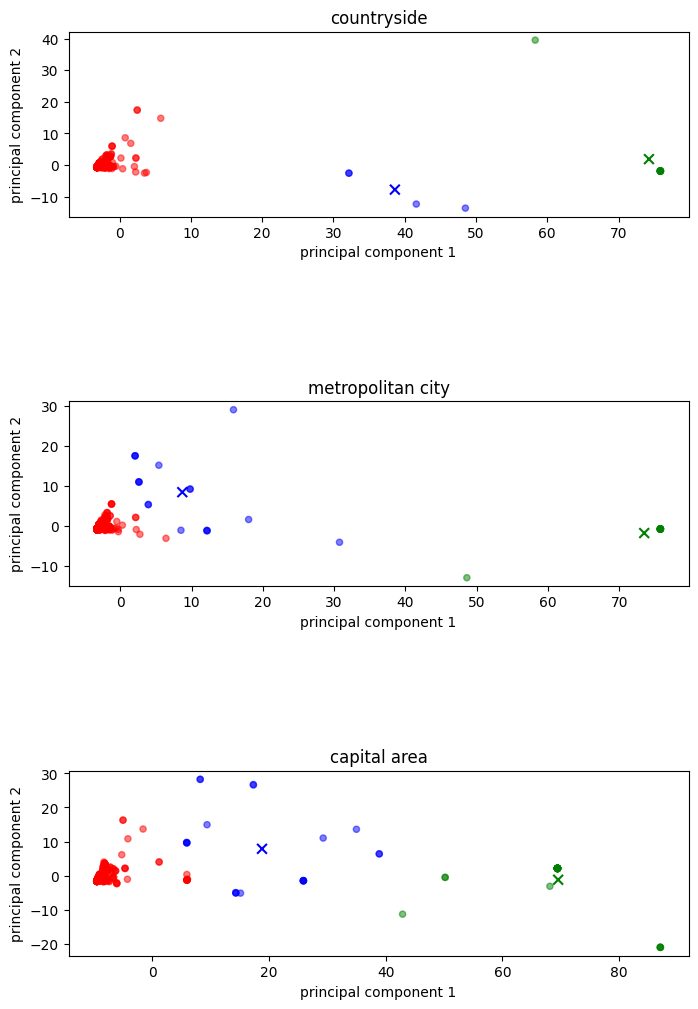

In [59]:
numClusters = 3
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # regionType : 0..2
    X = df_balanced_dropna[df_balanced_dropna["region"] == regionType].iloc[:, 1:]

    pca = PCA(n_components=2)
    pca_fit = pca.fit(X.values)
    X_pca2 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca2,
        columns=[
            "p_component 1",
            "p_component 2",
        ],
    )

    kmeans = KMeans(n_clusters=numClusters).fit(X_pca2)
    labels = kmeans.predict(X_pca2)
    dataPointColor = [colors[row] for row in labels]

    centroids = kmeans.cluster_centers_
    centroidColor = [colors[item] for item in range(numClusters)]

    ax = fig.add_subplot(3, 1, regionType + 1)

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        c=dataPointColor,
        s=20,
        alpha=0.5,
    )

    # centroids
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        c=centroidColor,
        s=50,
        marker="x",
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")

    print(pca_fit.explained_variance_ratio_)
    print(pca_fit.components_)
    print()

plt.show()


### PCA 로 주성분 3개를 갖고 Kmeans 클러스터링 수행  
의미있는 결과는 없었다.

d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
d:\anaconda3\envs\myvenv\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


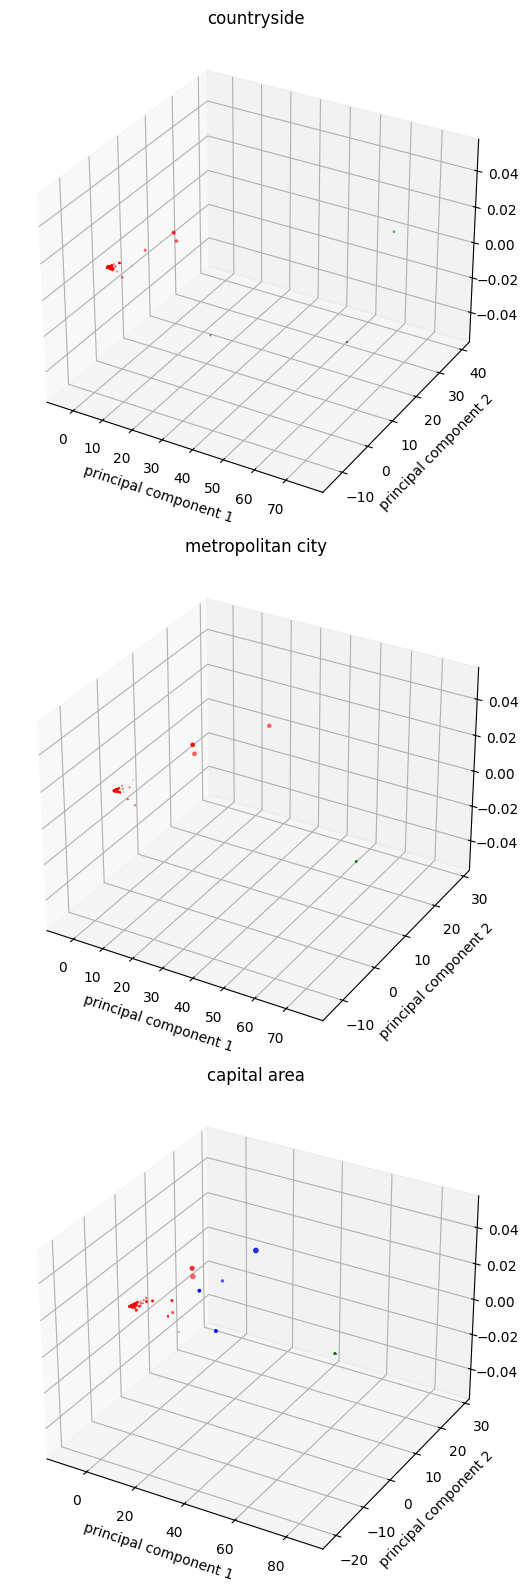

In [60]:
numClusters = 3
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(16, 16))
# fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # num : 0..2
    X = df_balanced_dropna[df_balanced_dropna["region"] == regionType].iloc[:, 1:]

    pca = PCA(n_components=3)
    pca_fit = pca.fit(X.values)
    X_pca3 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca3,
        columns=[
            "p_component 1",
            "p_component 2",
            "p_component 3",
        ],
    )

    kmeans = KMeans(n_clusters=numClusters).fit(X_pca3)
    labels = kmeans.predict(X_pca3)
    dataPointColor = [colors[row] for row in labels]

    ax = fig.add_subplot(3, 1, regionType + 1, projection="3d")

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        principalDf["p_component 3"],
        c=dataPointColor,
        alpha=0.5,
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")
    # ax.set_zlabel("principal component 3")

plt.tight_layout()
plt.show()


## DBSCAN  
사전에 클러스터 갯수를 지정하지 않고 클러스터링을 수행하기 위해 DBSCAN 사용.  

Kmeans 클러스터링 결과까지 함께 고려해봐도,  
#### '지역마다 세 개의 클러스터로 분류되는 경향이 있을 것이다'라는 가설은 틀린 것으로 보인다.  

{0, 1, -1}
The number of clusters (countryside):  2
{0, 1, -1}
The number of clusters (metropolitan city):  2
{0, 1, -1}
The number of clusters (capital area):  2


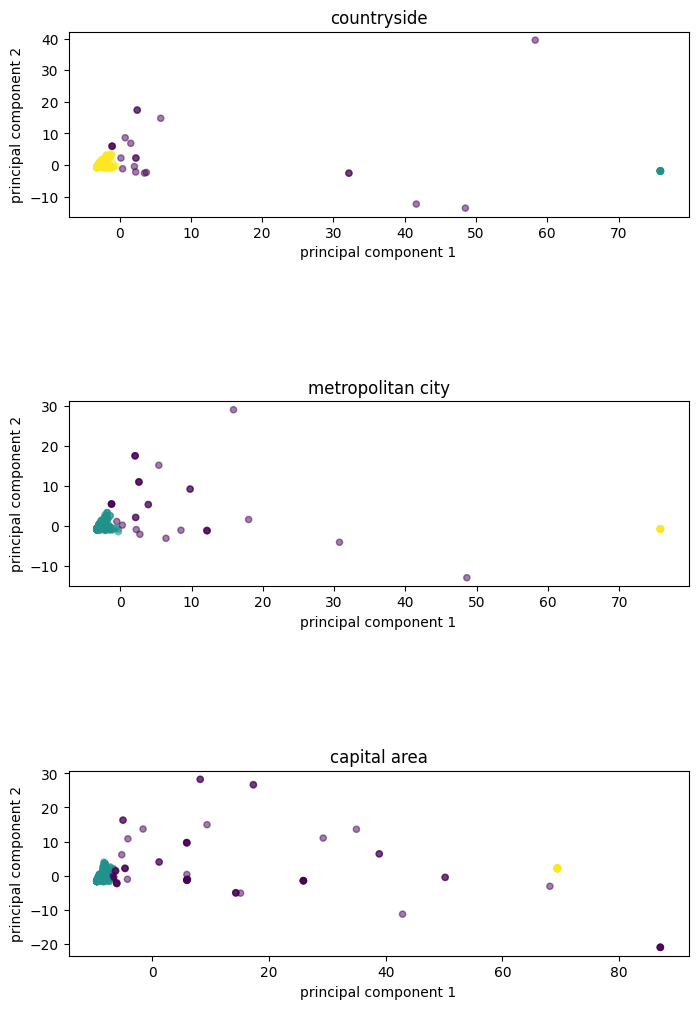

In [61]:
regionTypes = {0: "countryside", 1: "metropolitan city", 2: "capital area"}
colors = ["red", "green", "blue"]

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(hspace=1, wspace=0.2)

for regionType in regionTypes.keys():
    # regionType : 0..2
    X = df_balanced_dropna[df_balanced_dropna["region"] == regionType].iloc[:, 1:]

    pca = PCA(n_components=2)
    pca_fit = pca.fit(X.values)
    X_pca2 = pca_fit.transform(X.values)
    principalDf = pd.DataFrame(
        data=X_pca2,
        columns=[
            "p_component 1",
            "p_component 2",
        ],
    )

    predict = DBSCAN(eps=1, min_samples=10).fit_predict(X_pca2)

    ax = fig.add_subplot(3, 1, regionType + 1)

    # dataPoints
    plt.scatter(
        principalDf["p_component 1"],
        principalDf["p_component 2"],
        c=predict,
        s=20,
        alpha=0.5,
    )

    ax.set_title(regionTypes[regionType])
    ax.set_xlabel("principal component 1")
    ax.set_ylabel("principal component 2")

    # predict 결과가 -1 인 경우도 존재 (미분류)
    print(set(predict))
    print(f"The number of clusters ({regionTypes[regionType]}): ", len(set(predict)) - 1)

plt.show()

### [주제]

#### 지역에 따른 일자리의 질적인 차이가 존재하는가?

1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도 학습).
지역에 따라 일자리의 질적인 수준이 명확하게 나뉠수록, 구인 공고 데이터를 모아서 지역을 예측할 때 정확도가 높은 모델을 만들기 쉬울 것이다.

> 유의미한 성능으로 지역을 예측하는 데에 실패하였다.

2. {수도권, 비수도권 광역시, 그 외 지방} 지역 중에서, <수도권> 지역이 '대기업 및 중견기업이 내건 구인공고 비중'이 가장 크고 <그 외 지방> 지역이 해당 공고 비중이 가장 작을 것이다.  

> <수도권> 지역이 '대기업 및 중견기업이 내건 구인공고 비중' 이 제일 큰 것은 맞으나, 나머지 지역에 대해서는 예측이 틀렸었다.

3. 구인 공고 데이터 피쳐를 바탕으로 클러스터링 시에  크게 그룹 {우수한 일자리 / 중간 / 상대적으로 별로인 일자리} 로  나눌  수 있을 것이며, 수도권에 가까울수록 우수한 일자리 그룹에 소속된 데이터포인트가 다수일 것이다. (비지도 학습)

> 기대한 대로 클러스터가 형성되지 않았다.

## [최종결론]

#### 지역에 따른 일자리의 질적인 차이가 존재하는가? -> X  
하지만 수집한 데이터의 품질이 더 좋을 경우, 결과가 달라질 가능성이 충분히 존재함을 가설 3 검증과정에서 확인할 수 있었다.  